# MRC 데이터 EDA (탐색적 데이터 분석)

## 데이터 구조 개요

```
data/
├── train_dataset/           # 학습 데이터셋 (HuggingFace datasets 형식)
│   ├── dataset_dict.json    # {"splits": ["train", "validation"]}
│   ├── train/               # 학습 데이터
│   │   └── dataset.arrow    # Arrow 형식 데이터
│   └── validation/          # 검증 데이터
│       └── dataset.arrow
├── test_dataset/            # 테스트 데이터셋
│   ├── dataset_dict.json    # {"splits": ["validation"]}
│   └── validation/          # 테스트 데이터 (정답 없음)
│       └── dataset.arrow
├── wikipedia_documents.json # 위키피디아 문서 (Retrieval용, ~50MB)
├── sparse_embedding.bin     # 사전 계산된 Sparse Embedding
└── tfidv.bin               # TF-IDF 벡터라이저
```

### 데이터 스키마

**Train/Validation 데이터:**
- `id`: 질문 고유 ID (string)
- `question`: 질문 텍스트 (string)
- `context`: 정답이 포함된 문서 (string)
- `answers`: 정답 정보
  - `text`: 정답 텍스트 리스트
  - `answer_start`: 정답 시작 위치 리스트
- `document_id`: 문서 ID (int)
- `title`: 문서 제목 (string)

**Test 데이터:**
- `id`: 질문 고유 ID (string)
- `question`: 질문 텍스트 (string)
- (context와 answers는 포함되지 않음 - Open Domain QA)

## 1. 환경 설정 및 유틸리티 함수 정의

In [78]:
# 필요 라이브러리 import
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from collections import Counter
from pathlib import Path
from IPython.display import display

pd.options.display.float_format = "{:.2f}".format

# 한글 폰트 설정
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 경로 설정
DATA_DIR = Path("../data")
TRAIN_DATASET_PATH = DATA_DIR / "train_dataset"
TEST_DATASET_PATH = DATA_DIR / "test_dataset"
WIKI_PATH = DATA_DIR / "wikipedia_documents.json"

print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Train dataset path: {TRAIN_DATASET_PATH.resolve()}")
print(f"Test dataset path: {TEST_DATASET_PATH.resolve()}")

Data directory: /data/ephemeral/home/shared/datasets
Train dataset path: /data/ephemeral/home/shared/datasets/train_dataset
Test dataset path: /data/ephemeral/home/shared/datasets/test_dataset


In [79]:
# ============================================
# 재사용 가능한 EDA 유틸리티 모듈
# ============================================


class MRCDataExplorer:
    """MRC 데이터셋 탐색을 위한 유틸리티 클래스"""

    def __init__(self, dataset):
        """
        Args:
            dataset: HuggingFace Dataset 객체 또는 pandas DataFrame
        """
        if hasattr(dataset, "to_pandas"):
            self.df = dataset.to_pandas()
        elif isinstance(dataset, pd.DataFrame):
            self.df = dataset
        else:
            self.df = pd.DataFrame(dataset)

    def basic_info(self):
        """데이터셋 기본 정보 출력"""
        print("=" * 50)
        print("📊 데이터셋 기본 정보")
        print("=" * 50)
        print(f"샘플 수: {len(self.df):,}")
        print(f"컬럼: {list(self.df.columns)}")
        print(f"\n각 컬럼 타입:")
        print(self.df.dtypes)
        return self

    def sample_data(self, n=3, random_state=42):
        """랜덤 샘플 데이터 출력"""
        print("\n" + "=" * 50)
        print(f"📝 랜덤 샘플 데이터 ({n}개)")
        print("=" * 50)
        samples = self.df.sample(n=n, random_state=random_state)
        for idx, (_, row) in enumerate(samples.iterrows(), 1):
            print(f"\n--- 샘플 {idx} ---")
            print(f"ID: {row['id']}")
            print(f"질문: {row['question']}")
            if "context" in row:
                print(f"컨텍스트 (앞 200자): {row['context'][:200]}...")
            if "answers" in row:
                print(f"정답: {row['answers']}")
            if "title" in row:
                print(f"제목: {row['title']}")
        return self

    def text_length_stats(self, columns=["question", "context"]):
        """텍스트 길이 통계 분석"""
        stats_data = []
        for col in columns:
            if col in self.df.columns:
                lengths = self.df[col].str.len()
                stats = {
                    "컬럼": col,
                    "평균": lengths.mean(),
                    "중앙값": lengths.median(),
                    "최소": lengths.min(),
                    "최대": lengths.max(),
                    "표준편차": lengths.std(),
                }
                stats_data.append(stats)

        stats_df = pd.DataFrame(stats_data)
        return stats_df

    def plot_text_length_distribution(
        self, columns=("question", "context"), title=None, figsize=(14, 5)
    ):
        """텍스트 길이 분포 시각화"""
        fig, axes = plt.subplots(1, len(columns), figsize=figsize)
        if len(columns) == 1:
            axes = [axes]

        for ax, col in zip(axes, columns):
            if col in self.df.columns:
                lengths = self.df[col].str.len()

                ax.hist(lengths, bins=50, edgecolor="black", alpha=0.7)
                ax.axvline(
                    lengths.mean(),
                    color="red",
                    linestyle="--",
                    label=f"Mean: {lengths.mean():.1f}",
                )
                ax.axvline(
                    lengths.median(),
                    color="green",
                    linestyle="--",
                    label=f"Median: {lengths.median():.1f}",
                )

                ax.set_xlabel("Length (characters)")
                ax.set_ylabel("Frequency")
                ax.set_title(f"{col} Length Distribution")
                ax.legend()

        if title is not None:
            fig.suptitle(title, fontsize=16)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        return self

    def answer_analysis(self):
        """answers 컬럼 종합 분석 (개수 / 길이 / 위치)"""
        if "answers" not in self.df.columns or "context" not in self.df.columns:
            print("⚠️ answers 또는 context 컬럼이 없습니다.")
            return self

        print("\n" + "=" * 50)
        print("✅ 정답(answers) 종합 분석")
        print("=" * 50)

        answer_counts = []
        answer_lengths = []
        answer_starts = []
        relative_positions = []

        for _, row in self.df.iterrows():
            texts, starts = self._parse_answers(row["answers"])
            context_len = len(row["context"])

            answer_counts.append(len(texts))

            for t, s in zip(texts, starts):
                if t:
                    answer_lengths.append(len(t))
                if s is not None and context_len > 0:
                    answer_starts.append(s)
                    relative_positions.append(s / context_len)

        # -------------------------
        # 1) 정답 개수 분석
        # -------------------------
        count_dist = pd.Series(answer_counts).value_counts().sort_index()
        print("\n📌 정답 개수 분포")
        for k, v in count_dist.items():
            print(f"  {k}개 정답: {v:,}개")

        # -------------------------
        # 2) 정답 길이 분석
        # -------------------------
        print("\n📌 정답 길이 통계 (character)")
        print(f"  평균: {np.mean(answer_lengths):.2f}")
        print(f"  중앙값: {np.median(answer_lengths):.2f}")
        print(f"  최소: {np.min(answer_lengths)}")
        print(f"  최대: {np.max(answer_lengths)}")

        # -------------------------
        # 3) 정답 위치 분석
        # -------------------------
        print("\n📌 정답 위치 분석")

        if answer_starts:
            print(f"  시작 위치 평균: {np.mean(answer_starts):.1f}")
            print(f"  시작 위치 중앙값: {np.median(answer_starts):.1f}")

            # 상대 위치 기준 분포
            rel = np.array(relative_positions)
            front = np.mean(rel < 0.33) * 100
            mid = np.mean((rel >= 0.33) & (rel < 0.66)) * 100
            back = np.mean(rel >= 0.66) * 100

            print("  상대 위치 분포:")
            print(f"    앞쪽 (0~33%):  {front:.1f}%")
            print(f"    중간 (33~66%): {mid:.1f}%")
            print(f"    뒤쪽 (66~100%): {back:.1f}%")

        else:
            print("  ⚠️ answer_start 정보가 없습니다.")

        return self

    def _parse_answers(self, ans):
        """
        answers 필드를 정규화
        Returns:
            texts: List[str]
            starts: List[int | None]
        """
        texts, starts = [], []

        if isinstance(ans, dict):
            texts = ans.get("text", []) or []
            starts = ans.get("answer_start", []) or []
        elif isinstance(ans, (list, tuple)):
            texts = list(ans)
            starts = [None] * len(texts)
        elif isinstance(ans, str):
            texts = [ans]
            starts = [None]
        else:
            texts, starts = [], []

        if len(starts) != len(texts):
            starts = [None] * len(texts)

        return texts, starts

    def answer_structure_summary(self, max_examples: int = 5):
        """
        answers 컬럼 구조/분포 분석:
        - 샘플별 정답 개수 분포
        - 다수 정답 샘플 존재 여부
        - 예시 몇 개 출력
        """
        if "answers" not in self.df.columns:
            print("⚠️ answers 컬럼이 없습니다.")
            return self

        print("\n" + "=" * 50)
        print("🧩 answers 컬럼 구조 분석")
        print("=" * 50)

        answer_counts = []
        is_multi_flags = []
        is_empty_flags = []

        # multi-answer 샘플을 몇 개만 저장
        multi_examples = []

        for idx, row in self.df.iterrows():
            texts, starts = self._parse_answers(row["answers"])
            n = len(texts)
            answer_counts.append(n)
            is_multi = n > 1
            is_empty = n == 0
            is_multi_flags.append(is_multi)
            is_empty_flags.append(is_empty)

            if is_multi and len(multi_examples) < max_examples:
                multi_examples.append(
                    {
                        "row_index": idx,
                        "id": row.get("id", None),
                        "question": row.get("question", None),
                        "num_answers": n,
                        "answers": texts,
                        "answer_start": starts,
                    }
                )

        counts_series = pd.Series(answer_counts)
        dist = counts_series.value_counts().sort_index()

        total = len(counts_series)
        num_empty = sum(is_empty_flags)
        num_single = sum(c == 1 for c in answer_counts)
        num_multi = sum(c > 1 for c in answer_counts)

        print(f"총 샘플 수: {total:,}")
        print(f"  - 정답 없음(0개): {num_empty:,}개")
        print(f"  - 정답 1개:       {num_single:,}개")
        print(f"  - 정답 2개 이상:  {num_multi:,}개")

        print("\n정답 개수 분포 (정확한 개수별 샘플 수):")
        for k, v in dist.items():
            print(f"  {k:2d}개 정답: {v:,}개")

        if num_multi > 0:
            print("\n✅ 여러 개의 정답이 존재하는 샘플이 있습니다.")
            print(f"  (아래는 예시 {len(multi_examples)}개)")
            for ex in multi_examples:
                print("\n--- Multi-answer 예시 ---")
                print(f"row index: {ex['row_index']}")
                if ex["id"] is not None:
                    print(f"id: {ex['id']}")
                if ex["question"] is not None:
                    print(f"질문: {ex['question']}")
                print(f"정답 개수: {ex['num_answers']}")
                for i, (t, s) in enumerate(zip(ex["answers"], ex["answer_start"])):
                    print(f"  [{i}] text='{t}', start={s}")
        else:
            print("\n❌ 여러 개의 정답(2개 이상)을 가진 샘플은 없습니다.")

        return self

    def word_count_analysis(self, column="question"):
        """단어 수 분석"""
        if column not in self.df.columns:
            print(f"⚠️ {column} 컬럼이 없습니다.")
            return self

        print("\n" + "=" * 50)
        print(f"📝 {column} 단어 수 분석")
        print("=" * 50)

        word_counts = self.df[column].str.split().str.len()
        print(f"평균 단어 수: {word_counts.mean():.2f}")
        print(f"중앙값: {word_counts.median():.2f}")
        print(f"최소: {word_counts.min()}")
        print(f"최대: {word_counts.max()}")

        return self

    def duplicate_check(self, columns=["question", "id"]):
        """중복 데이터 확인"""
        print("\n" + "=" * 50)
        print("🔍 중복 데이터 확인")
        print("=" * 50)

        for col in columns:
            if col in self.df.columns:
                n_unique = self.df[col].nunique()
                n_total = len(self.df)
                n_dup = n_total - n_unique
                print(
                    f"{col}: 총 {n_total:,}개 중 고유값 {n_unique:,}개 (중복: {n_dup:,}개)"
                )

        return self


def load_mrc_datasets(train_path, test_path=None):
    """MRC 데이터셋 로드 유틸리티 (Pandas DataFrame 반환)

    Args:
        train_path: 학습 데이터셋 경로
        test_path: 테스트 데이터셋 경로 (선택)

    Returns:
        dict: 로드된 데이터셋 딕셔너리 (Key: split name, Value: pd.DataFrame)
    """
    data_frames = {}

    # 학습 데이터셋 로드
    if Path(train_path).exists():
        train_dataset = load_from_disk(str(train_path))
        print(f"✅ Train dataset loaded:")
        if "train" in train_dataset:
            df = train_dataset["train"].to_pandas()
            print(f"   - train: {len(df):,} samples")
            data_frames["train"] = df
        if "validation" in train_dataset:
            df = train_dataset["validation"].to_pandas()
            print(f"   - validation: {len(df):,} samples")
            data_frames["validation"] = df

    # 테스트 데이터셋 로드
    if test_path and Path(test_path).exists():
        test_dataset = load_from_disk(str(test_path))
        print(f"✅ Test dataset loaded:")
        if "validation" in test_dataset:
            df = test_dataset["validation"].to_pandas()
            print(f"   - test: {len(df):,} samples")
            data_frames["test"] = df
        elif "test" in test_dataset:
            df = test_dataset["test"].to_pandas()
            print(f"   - test: {len(df):,} samples")
            data_frames["test"] = df

    return data_frames


def load_wikipedia_documents(wiki_path, sample_n=None):
    """위키피디아 문서 로드 유틸리티

    Args:
        wiki_path: 위키피디아 JSON 파일 경로
        sample_n: 샘플링할 문서 수 (None이면 전체 로드)

    Returns:
        pd.DataFrame: 위키피디아 문서 데이터프레임
    """
    print(f"Loading wikipedia documents from {wiki_path}...")

    with open(wiki_path, "r", encoding="utf-8") as f:
        wiki_data = json.load(f)

    # dict 형태를 DataFrame으로 변환
    wiki_df = pd.DataFrame.from_dict(wiki_data, orient="index")
    wiki_df.reset_index(inplace=True)
    wiki_df.rename(columns={"index": "doc_key"}, inplace=True)

    if sample_n:
        wiki_df = wiki_df.sample(n=sample_n, random_state=42)

    print(f"✅ Wikipedia documents loaded: {len(wiki_df):,} documents")
    return wiki_df


print("✅ 유틸리티 클래스 및 함수 정의 완료!")

✅ 유틸리티 클래스 및 함수 정의 완료!


## 2. 데이터셋 로드

In [80]:
# 데이터셋 로드 (DataFrame으로 반환됨)
datasets = load_mrc_datasets(TRAIN_DATASET_PATH, TEST_DATASET_PATH)

# 개별 DataFrame 접근
train_df = datasets["train"]
valid_df = datasets["validation"]
test_df = datasets["test"]

# Train + Valid 데이터 합치기
print("📊 Train + Validation 데이터 결합...")
train_valid_df = pd.concat([train_df, valid_df], ignore_index=True)

print(f"\n📊 데이터셋 크기 요약:")
print(f"  - Train: {len(train_df):,} samples")
print(f"  - Validation: {len(valid_df):,} samples")
print(f"  - Train + Valid: {len(train_valid_df):,} samples")
print(f"  - Test: {len(test_df):,} samples")

print(f"\n✅ DataFrame 준비 완료:")
print(f"  - train_df: {train_df.shape}")
print(f"  - valid_df: {valid_df.shape}")
print(f"  - test_df: {test_df.shape}")
print(f"  - train_valid_df: {train_valid_df.shape}")

✅ Train dataset loaded:
   - train: 3,952 samples
   - validation: 240 samples
✅ Test dataset loaded:
   - test: 600 samples
📊 Train + Validation 데이터 결합...

📊 데이터셋 크기 요약:
  - Train: 3,952 samples
  - Validation: 240 samples
  - Train + Valid: 4,192 samples
  - Test: 600 samples

✅ DataFrame 준비 완료:
  - train_df: (3952, 7)
  - valid_df: (240, 7)
  - test_df: (600, 2)
  - train_valid_df: (4192, 7)


In [81]:
# MRCDataExplorer 초기화
train_explorer = MRCDataExplorer(train_df)
valid_explorer = MRCDataExplorer(valid_df)
test_explorer = MRCDataExplorer(test_df)

## 3. train + valid 데이터 분석

In [82]:
# 상위 5개 샘플 확인
print(f"\n📝 상위 5개 샘플:")
display(train_df.head())

# 기본 정보 확인
train_explorer.basic_info()


📝 상위 5개 샘플:


,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


📊 데이터셋 기본 정보
샘플 수: 3,952
컬럼: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__']

각 컬럼 타입:
title                object
context              object
question             object
id                   object
answers              object
document_id           int64
__index_level_0__     int64
dtype: object


In [83]:
# 텍스트 길이 통계
print("train: text 길이 분석")
display(train_explorer.text_length_stats(["question", "context"]))
print("val: text 길이 분석")
display(valid_explorer.text_length_stats(["question", "context"]))

train: text 길이 분석


,컬럼,평균,중앙값,최소,최대,표준편차
0,question,29.32,29.00,8,78,8.73
1,context,920.22,819.00,512,2059,356.50


val: text 길이 분석


,컬럼,평균,중앙값,최소,최대,표준편차
0,question,29.20,29.00,9,59,8.73
1,context,916.73,820.50,517,2064,360.03


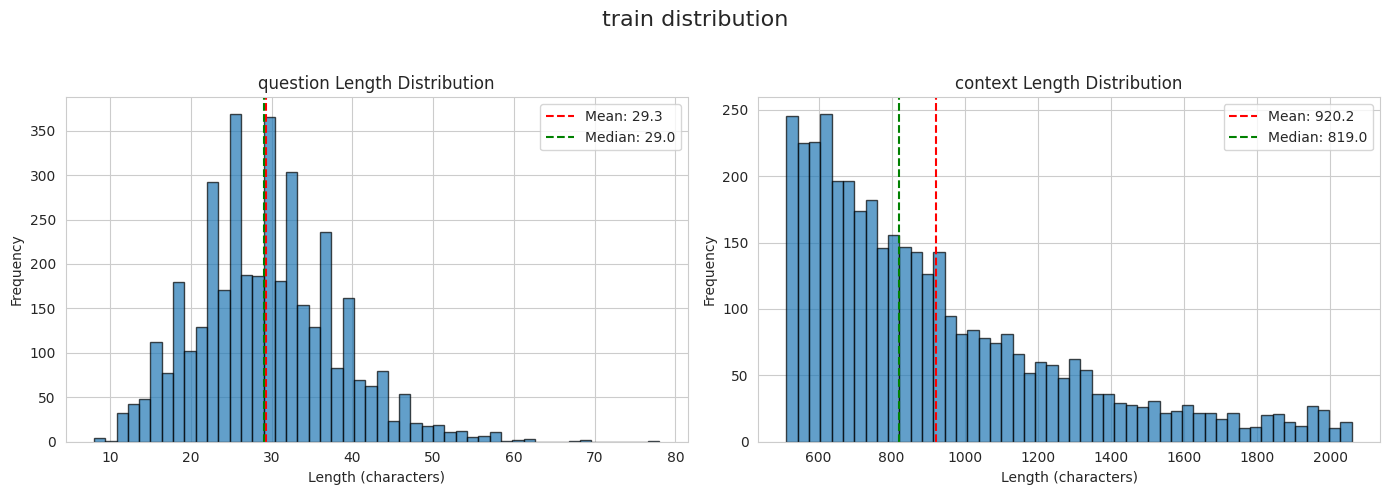

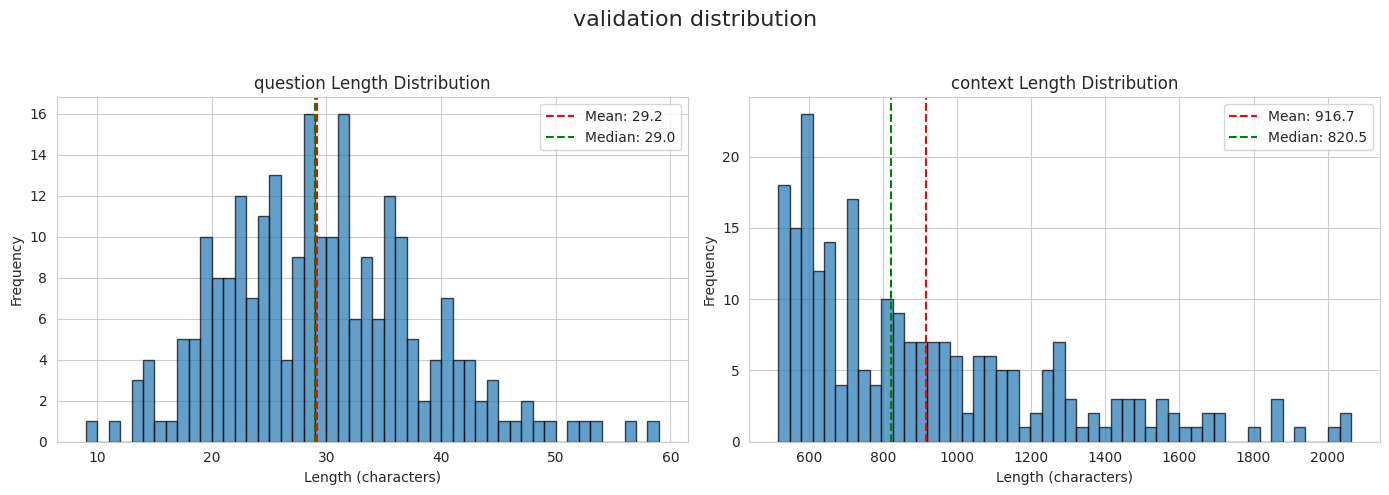

In [84]:
# 텍스트 길이 분포 시각화
train_explorer.plot_text_length_distribution(
    ["question", "context"],
    "train distribution",
)
valid_explorer.plot_text_length_distribution(
    ["question", "context"],
    "validation distribution",
)

In [85]:
train_explorer.answer_structure_summary()
valid_explorer.answer_structure_summary()


🧩 answers 컬럼 구조 분석
총 샘플 수: 3,952
  - 정답 없음(0개): 0개
  - 정답 1개:       3,952개
  - 정답 2개 이상:  0개

정답 개수 분포 (정확한 개수별 샘플 수):
   1개 정답: 3,952개

❌ 여러 개의 정답(2개 이상)을 가진 샘플은 없습니다.

🧩 answers 컬럼 구조 분석
총 샘플 수: 240
  - 정답 없음(0개): 0개
  - 정답 1개:       240개
  - 정답 2개 이상:  0개

정답 개수 분포 (정확한 개수별 샘플 수):
   1개 정답: 240개

❌ 여러 개의 정답(2개 이상)을 가진 샘플은 없습니다.


In [86]:
# 정답 분석
print("\n📝 train 정답 분석:")
train_explorer.answer_analysis()
print("\n📝 valid 정답 분석:")
valid_explorer.answer_analysis()


📝 train 정답 분석:

✅ 정답(answers) 종합 분석

📌 정답 개수 분포
  1개 정답: 3,952개

📌 정답 길이 통계 (character)
  평균: 6.28
  중앙값: 5.00
  최소: 1
  최대: 83

📌 정답 위치 분석
  시작 위치 평균: 383.5
  시작 위치 중앙값: 316.0
  상대 위치 분포:
    앞쪽 (0~33%):  44.8%
    중간 (33~66%): 30.8%
    뒤쪽 (66~100%): 24.4%

📝 valid 정답 분석:

✅ 정답(answers) 종합 분석

📌 정답 개수 분포
  1개 정답: 240개

📌 정답 길이 통계 (character)
  평균: 6.91
  중앙값: 5.00
  최소: 1
  최대: 64

📌 정답 위치 분석
  시작 위치 평균: 399.8
  시작 위치 중앙값: 331.0
  상대 위치 분포:
    앞쪽 (0~33%):  40.4%
    중간 (33~66%): 35.7%
    뒤쪽 (66~100%): 23.8%


In [87]:
# 중복 데이터 확인
print("train 중복 데이터 확인")
train_explorer.duplicate_check(["question", "id", "context"])
print("valid 중복 데이터 확인")
valid_explorer.duplicate_check(["question", "id", "context"])

train 중복 데이터 확인

🔍 중복 데이터 확인
question: 총 3,952개 중 고유값 3,952개 (중복: 0개)
id: 총 3,952개 중 고유값 3,952개 (중복: 0개)
context: 총 3,952개 중 고유값 3,340개 (중복: 612개)
valid 중복 데이터 확인

🔍 중복 데이터 확인
question: 총 240개 중 고유값 240개 (중복: 0개)
id: 총 240개 중 고유값 240개 (중복: 0개)
context: 총 240개 중 고유값 235개 (중복: 5개)


## 5. Test 데이터 분석

Test 데이터는 Open Domain QA 형식으로, `question`과 `id`만 포함합니다.
실제 평가 시에는 Retrieval을 통해 context를 찾아야 합니다.

In [88]:
# Test 데이터 확인
print("=" * 50)
print("📊 Test 데이터셋 정보")
print("=" * 50)
print(f"샘플 수: {len(test_df):,}")
print(f"컬럼: {list(test_df.columns)}")
display(test_df.head())

📊 Test 데이터셋 정보
샘플 수: 600
컬럼: ['question', 'id']


,question,id
0,유령'은 어느 행성에서 지구로 왔는가?,mrc-1-000653
1,용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?,mrc-1-001113
2,돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?,mrc-0-002191
3,"마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?",mrc-0-003951
4,디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?,mrc-1-001272


📏 Test 질문 길이 통계
평균: 29.55
중앙값: 29.00
최소: 8
최대: 62


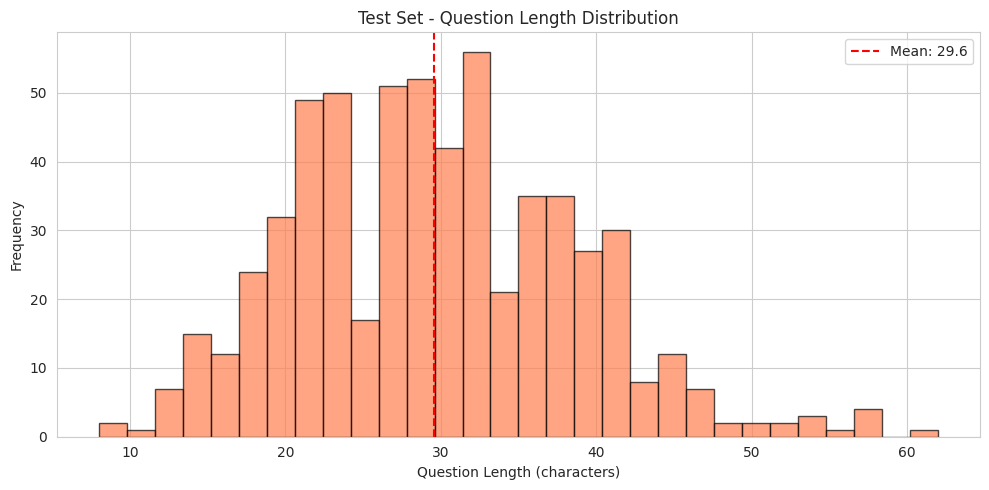

In [89]:
# Test 질문 길이 분석
test_question_lengths = test_df["question"].str.len()

print("=" * 50)
print("📏 Test 질문 길이 통계")
print("=" * 50)
print(f"평균: {test_question_lengths.mean():.2f}")
print(f"중앙값: {test_question_lengths.median():.2f}")
print(f"최소: {test_question_lengths.min()}")
print(f"최대: {test_question_lengths.max()}")

# 시각화
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(test_question_lengths, bins=30, edgecolor="black", alpha=0.7, color="coral")
ax.axvline(
    test_question_lengths.mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {test_question_lengths.mean():.1f}",
)
ax.set_xlabel("Question Length (characters)")
ax.set_ylabel("Frequency")
ax.set_title("Test Set - Question Length Distribution")
ax.legend()
plt.tight_layout()
plt.show()

In [90]:
def compare_dataset_distributions_normalized(datasets_dict, test_set_name=None):
    """
    여러 데이터셋의 분포를 정규화하여 비교하는 함수
    (0-100 스케일로 정규화하여 표본 크기 차이 제거)

    Args:
        datasets_dict: {'name': dataframe} 형태의 딕셔너리
        test_set_name: test 데이터셋 이름 (질문만 있는 경우)
    """
    print("\n" + "=" * 70)
    print("📊 정규화된 데이터셋 분포 비교 분석")
    print("=" * 70)

    comparison_data = []

    for ds_name, df in datasets_dict.items():
        # df = ds.to_pandas() # 이미 DataFrame임

        stats = {
            "Dataset": ds_name,
            "샘플 수": len(df),
            "질문 길이 평균": df["question"].str.len().mean(),
            "질문 길이 중앙값": df["question"].str.len().median(),
            "질문 길이 표준편차": df["question"].str.len().std(),
        }

        # test set이 아닌 경우만 context 분석
        if test_set_name is None or ds_name != test_set_name:
            if "context" in df.columns:
                stats["컨텍스트 길이 평균"] = df["context"].str.len().mean()
                stats["컨텍스트 길이 중앙값"] = df["context"].str.len().median()
                stats["컨텍스트 길이 표준편차"] = df["context"].str.len().std()

        comparison_data.append(stats)

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


def visualize_dataset_comparison_normalized(train_df, valid_df, test_df=None):
    """정규화된 데이터셋 분포 비교 시각화 (스케일 최적화 + 겹친/분리 그래프)"""
    # train_df = train_data.to_pandas()
    # valid_df = valid_data.to_pandas()

    # ===== 1. 겹친 그래프 (Overlapped) =====
    print("\n📊 생성 중: 겹친 분포 비교 그래프...")
    fig_overlap, axes_overlap = plt.subplots(2, 2, figsize=(16, 12))

    # 1-1. 질문 길이 분포 (겹침)
    ax = axes_overlap[0, 0]
    question_lengths_all = list(train_df["question"].str.len()) + list(
        valid_df["question"].str.len()
    )
    if test_df is not None:
        # test_df = test_data.to_pandas()
        question_lengths_all += list(test_df["question"].str.len())

    min_q = min(question_lengths_all)
    max_q = max(question_lengths_all)
    bins = 35

    train_q_counts, bin_edges = np.histogram(
        train_df["question"].str.len(), bins=bins, range=(min_q, max_q)
    )
    valid_q_counts, _ = np.histogram(
        valid_df["question"].str.len(), bins=bins, range=(min_q, max_q)
    )

    # 데이터셋별 최대값으로 스케일 조정 (더 나은 시각화)
    train_q_norm = (train_q_counts / train_q_counts.max()) * 100
    valid_q_norm = (valid_q_counts / valid_q_counts.max()) * 100

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = np.diff(bin_edges)[0]

    ax.plot(
        bin_centers,
        train_q_norm,
        marker="o",
        linewidth=2.5,
        markersize=4,
        label="Train",
        color="steelblue",
        alpha=0.8,
    )
    ax.plot(
        bin_centers,
        valid_q_norm,
        marker="s",
        linewidth=2.5,
        markersize=4,
        label="Validation",
        color="coral",
        alpha=0.8,
    )

    if test_df is not None:
        # test_df = test_data.to_pandas()
        test_q_counts, _ = np.histogram(
            test_df["question"].str.len(), bins=bins, range=(min_q, max_q)
        )
        test_q_norm = (test_q_counts / test_q_counts.max()) * 100
        ax.plot(
            bin_centers,
            test_q_norm,
            marker="^",
            linewidth=2.5,
            markersize=4,
            label="Test",
            color="mediumseagreen",
            alpha=0.8,
        )

    ax.fill_between(bin_centers, train_q_norm, alpha=0.2, color="steelblue")
    ax.fill_between(bin_centers, valid_q_norm, alpha=0.2, color="coral")
    if test_df is not None:
        ax.fill_between(bin_centers, test_q_norm, alpha=0.2, color="mediumseagreen")

    ax.set_xlabel("Question Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Question Length Distribution (Overlapped)", fontsize=12, fontweight="bold"
    )
    ax.set_ylim(0, 110)
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="both", alpha=0.3, linestyle="--")

    # 1-2. 컨텍스트 길이 분포 (겹침)
    ax = axes_overlap[0, 1]
    context_lengths_all = list(train_df["context"].str.len()) + list(
        valid_df["context"].str.len()
    )
    min_c = min(context_lengths_all)
    max_c = max(context_lengths_all)

    train_c_counts, bin_edges = np.histogram(
        train_df["context"].str.len(), bins=bins, range=(min_c, max_c)
    )
    valid_c_counts, _ = np.histogram(
        valid_df["context"].str.len(), bins=bins, range=(min_c, max_c)
    )

    train_c_norm = (train_c_counts / train_c_counts.max()) * 100
    valid_c_norm = (valid_c_counts / valid_c_counts.max()) * 100

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    ax.plot(
        bin_centers,
        train_c_norm,
        marker="o",
        linewidth=2.5,
        markersize=4,
        label="Train",
        color="steelblue",
        alpha=0.8,
    )
    ax.plot(
        bin_centers,
        valid_c_norm,
        marker="s",
        linewidth=2.5,
        markersize=4,
        label="Validation",
        color="coral",
        alpha=0.8,
    )

    ax.fill_between(bin_centers, train_c_norm, alpha=0.2, color="steelblue")
    ax.fill_between(bin_centers, valid_c_norm, alpha=0.2, color="coral")

    ax.set_xlabel("Context Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Context Length Distribution (Overlapped)", fontsize=12, fontweight="bold"
    )
    ax.set_ylim(0, 110)
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="both", alpha=0.3, linestyle="--")

    # 1-3. 질문 단어 수 분포 (겹침)
    ax = axes_overlap[1, 0]
    train_word_counts = train_df["question"].str.split().str.len()
    valid_word_counts = valid_df["question"].str.split().str.len()

    word_counts_all = list(train_word_counts) + list(valid_word_counts)
    if test_df is not None:
        # test_df = test_data.to_pandas()
        test_word_counts = test_df["question"].str.split().str.len()
        word_counts_all += list(test_word_counts)

    min_w = min(word_counts_all)
    max_w = max(word_counts_all)
    bins_w = int(max_w - min_w) + 1

    train_w_counts, bin_edges = np.histogram(
        train_word_counts, bins=bins_w, range=(min_w - 0.5, max_w + 0.5)
    )
    valid_w_counts, _ = np.histogram(
        valid_word_counts, bins=bins_w, range=(min_w - 0.5, max_w + 0.5)
    )

    train_w_norm = (train_w_counts / train_w_counts.max()) * 100
    valid_w_norm = (valid_w_counts / valid_w_counts.max()) * 100

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    ax.plot(
        bin_centers,
        train_w_norm,
        marker="o",
        linewidth=2.5,
        markersize=4,
        label="Train",
        color="steelblue",
        alpha=0.8,
    )
    ax.plot(
        bin_centers,
        valid_w_norm,
        marker="s",
        linewidth=2.5,
        markersize=4,
        label="Validation",
        color="coral",
        alpha=0.8,
    )

    if test_df is not None:
        # test_df = test_data.to_pandas()
        test_word_counts = test_df["question"].str.split().str.len()
        test_w_counts, _ = np.histogram(
            test_word_counts, bins=bins_w, range=(min_w - 0.5, max_w + 0.5)
        )
        test_w_norm = (test_w_counts / test_w_counts.max()) * 100
        ax.plot(
            bin_centers,
            test_w_norm,
            marker="^",
            linewidth=2.5,
            markersize=4,
            label="Test",
            color="mediumseagreen",
            alpha=0.8,
        )

    ax.fill_between(bin_centers, train_w_norm, alpha=0.2, color="steelblue")
    ax.fill_between(bin_centers, valid_w_norm, alpha=0.2, color="coral")
    if test_df is not None:
        ax.fill_between(bin_centers, test_w_norm, alpha=0.2, color="mediumseagreen")

    ax.set_xlabel("Question Word Count", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Question Word Count Distribution (Overlapped)", fontsize=12, fontweight="bold"
    )
    ax.set_ylim(0, 110)
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="both", alpha=0.3, linestyle="--")

    # 1-4. 데이터셋 크기
    ax = axes_overlap[1, 1]
    sizes = [len(train_df), len(valid_df)]
    labels = ["Train", "Validation"]
    colors = ["steelblue", "coral"]

    if test_df is not None:
        sizes.append(len(test_df))
        labels.append("Test")
        colors.append("mediumseagreen")

    bars = ax.bar(
        labels, sizes, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5
    )
    ax.set_ylabel("Sample Count", fontsize=11, fontweight="bold")
    ax.set_title("Dataset Size Comparison", fontsize=12, fontweight="bold")

    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(size):,}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    ax.grid(axis="y", alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.show()

    # ===== 2. 분리 그래프 (Separated) =====
    print("📊 생성 중: 분리된 분포 비교 그래프...")
    fig_sep, axes_sep = plt.subplots(3, 3, figsize=(18, 14))

    # 2-1. 질문 길이
    for idx, (ds_name, (df, color)) in enumerate(
        zip(
            ["Train", "Validation", "Test"],
            [
                (train_df, "steelblue"),
                (valid_df, "coral"),
                (test_df, "mediumseagreen" if test_df is not None else None),
            ],
        )
    ):
        if df is None:
            axes_sep[0, idx].text(
                0.5,
                0.5,
                "N/A",
                ha="center",
                va="center",
                fontsize=12,
                transform=axes_sep[0, idx].transAxes,
            )
            axes_sep[0, idx].set_title(f"{ds_name}", fontsize=12, fontweight="bold")
            continue

        # df_tmp = data.to_pandas()
        lengths = df["question"].str.len()
        ax = axes_sep[0, idx]
        ax.hist(
            lengths, bins=35, color=color, alpha=0.7, edgecolor="black", linewidth=0.8
        )
        ax.axvline(
            lengths.mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {lengths.mean():.0f}",
        )
        ax.axvline(
            lengths.median(),
            color="green",
            linestyle="--",
            linewidth=2,
            label=f"Median: {lengths.median():.0f}",
        )
        ax.set_xlabel("Length (chars)", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.set_title(f"{ds_name} - Question Length", fontsize=11, fontweight="bold")
        ax.legend(fontsize=9)
        ax.grid(axis="y", alpha=0.3)

    # 2-2. 컨텍스트 길이
    context_datasets = [
        ("Train", train_df, "steelblue"),
        ("Validation", valid_df, "coral"),
    ]
    for idx, (ds_name, df, color) in enumerate(context_datasets):
        # df_tmp = data.to_pandas()
        lengths = df["context"].str.len()
        ax = axes_sep[1, idx]
        ax.hist(
            lengths, bins=35, color=color, alpha=0.7, edgecolor="black", linewidth=0.8
        )
        ax.axvline(
            lengths.mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {lengths.mean():.0f}",
        )
        ax.axvline(
            lengths.median(),
            color="green",
            linestyle="--",
            linewidth=2,
            label=f"Median: {lengths.median():.0f}",
        )
        ax.set_xlabel("Length (chars)", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.set_title(f"{ds_name} - Context Length", fontsize=11, fontweight="bold")
        ax.legend(fontsize=9)
        ax.grid(axis="y", alpha=0.3)

    axes_sep[1, 2].text(
        0.5,
        0.5,
        "Test에는\nContext 없음",
        ha="center",
        va="center",
        fontsize=11,
        transform=axes_sep[1, 2].transAxes,
        style="italic",
    )
    axes_sep[1, 2].set_xticks([])
    axes_sep[1, 2].set_yticks([])

    # 2-3. 정답 길이 (Train, Valid만 - Test는 정답 없음)
    for idx, (ds_name, (df, color)) in enumerate(
        zip(
            ["Train", "Validation", "N/A"],
            [(train_df, "steelblue"), (valid_df, "coral"), (None, None)],
        )
    ):
        ax = axes_sep[2, idx]

        if df is None or "answers" not in df.columns:
            ax.text(
                0.5,
                0.5,
                "N/A",
                ha="center",
                va="center",
                fontsize=12,
                transform=ax.transAxes,
            )
            ax.set_title(f"{ds_name} - Answer Length", fontsize=11, fontweight="bold")
            continue

        # df_tmp = data.to_pandas()
        answer_lengths = []
        for ans_dict in df["answers"]:
            if isinstance(ans_dict, dict) and ans_dict.get("text"):
                for ans_text in ans_dict["text"]:
                    answer_lengths.append(len(ans_text))

        if answer_lengths:
            ax.hist(
                answer_lengths,
                bins=30,
                color=color,
                alpha=0.7,
                edgecolor="black",
                linewidth=0.8,
            )
            ax.axvline(
                np.mean(answer_lengths),
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {np.mean(answer_lengths):.0f}",
            )
            ax.axvline(
                np.median(answer_lengths),
                color="green",
                linestyle="--",
                linewidth=2,
                label=f"Median: {np.median(answer_lengths):.0f}",
            )
            ax.set_xlabel("Length (chars)", fontsize=10)
            ax.set_ylabel("Frequency", fontsize=10)
            ax.set_title(f"{ds_name} - Answer Length", fontsize=11, fontweight="bold")
            ax.legend(fontsize=9)
            ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


📊 정규화된 데이터셋 분포 비교 분석


,Dataset,샘플 수,질문 길이 평균,질문 길이 중앙값,질문 길이 표준편차,컨텍스트 길이 평균,컨텍스트 길이 중앙값,컨텍스트 길이 표준편차
0,Train,3952,29.32,29.00,8.73,920.22,819.00,356.50
1,Validation,240,29.20,29.00,8.73,916.73,820.50,360.03
2,Test,600,29.55,29.00,8.96,NaN,NaN,NaN



📊 생성 중: 겹친 분포 비교 그래프...


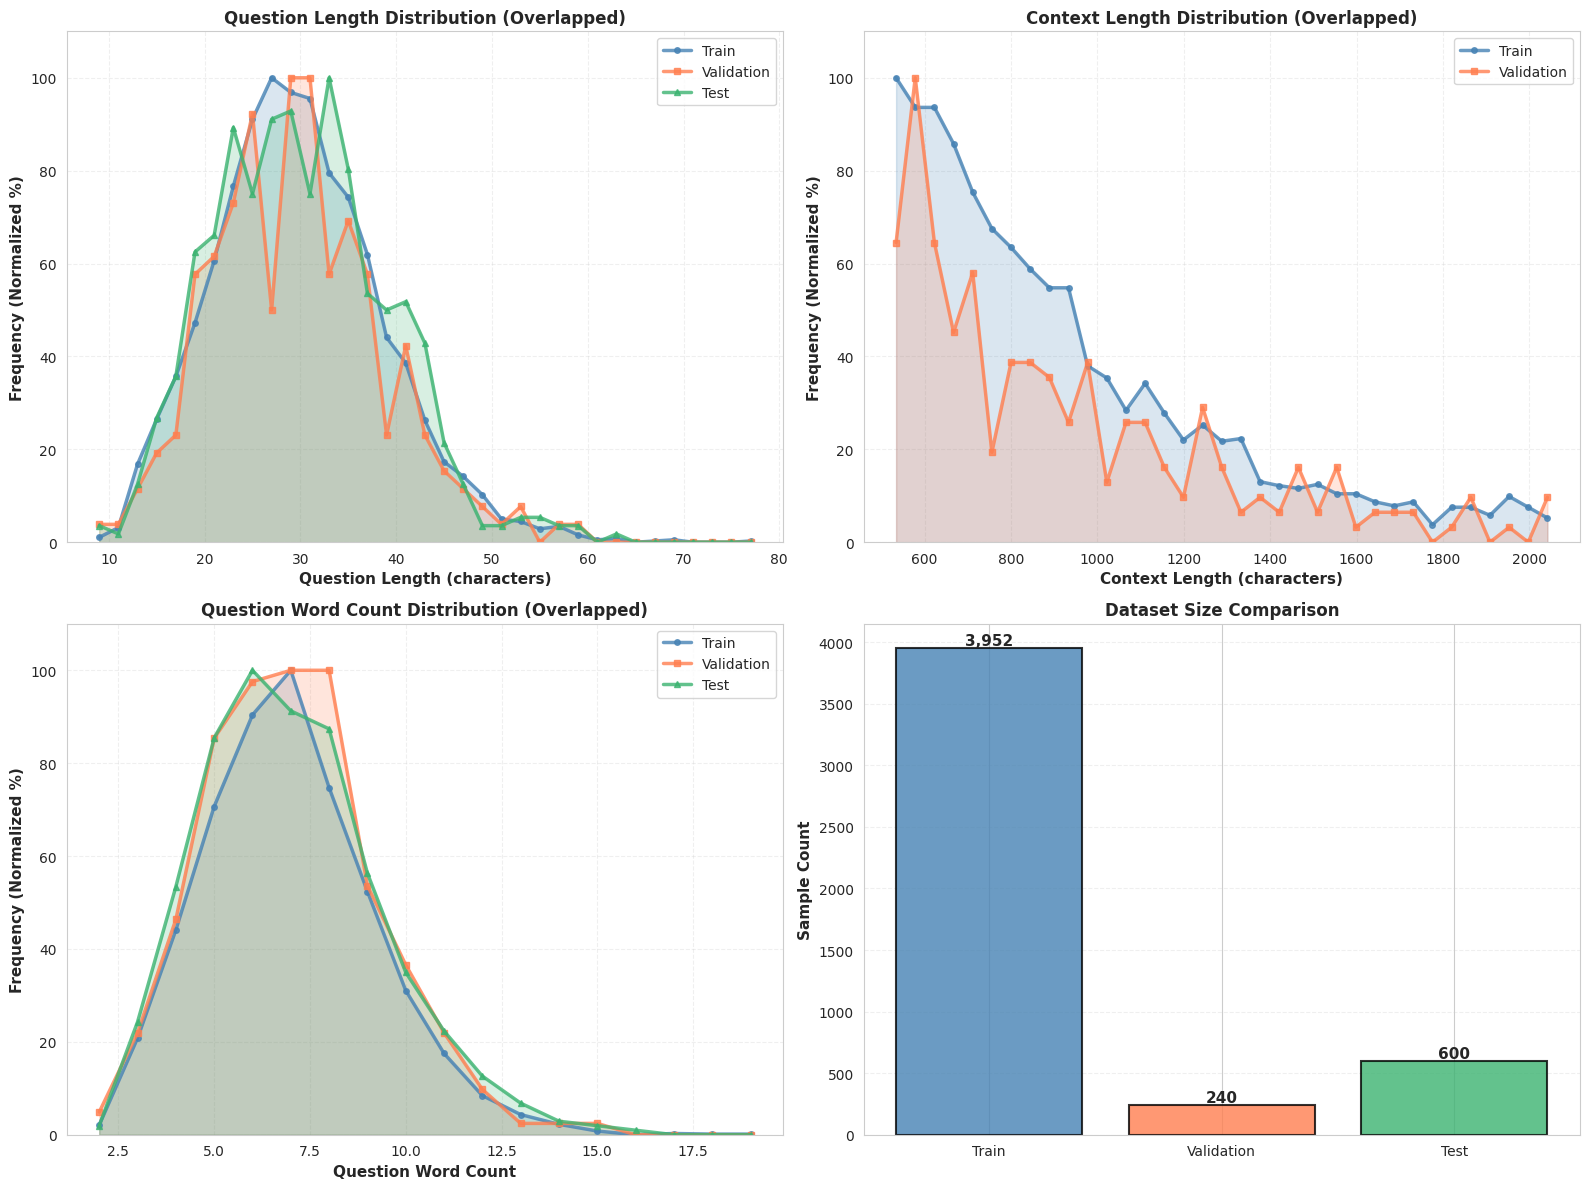

📊 생성 중: 분리된 분포 비교 그래프...


/tmp/ipykernel_696759/2497375980.py:452: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_696759/2497375980.py:452: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_696759/2497375980.py:452: UserWarning: Glyph 50630 (\N{HANGUL SYLLABLE EOBS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_696759/2497375980.py:452: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/ephemeral/home/shared/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/shared/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canva

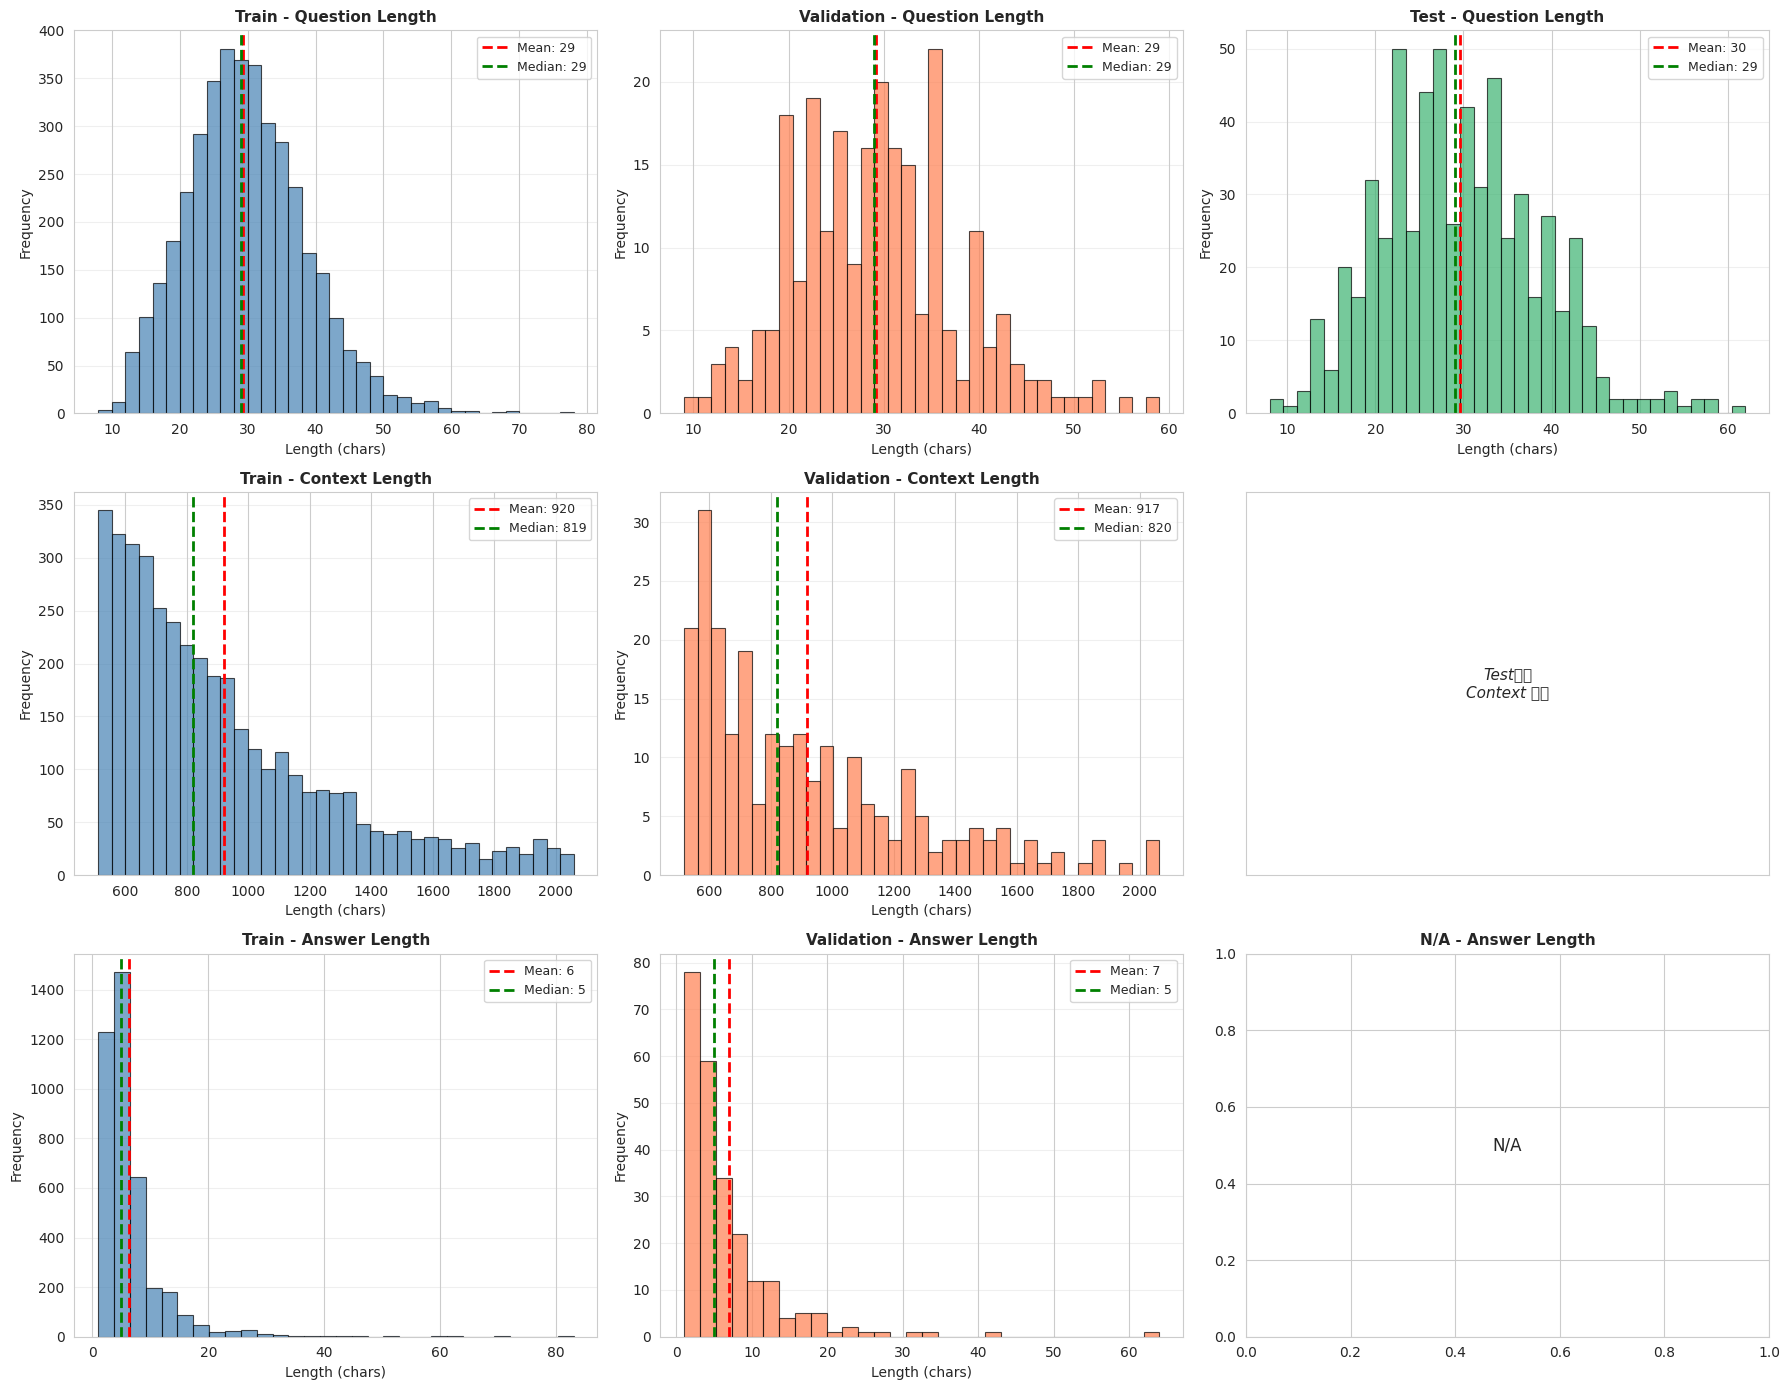

In [91]:
# 정규화된 데이터셋 분포 비교
datasets_for_comparison = {"Train": train_df, "Validation": valid_df, "Test": test_df}

comparison_df = compare_dataset_distributions_normalized(
    datasets_for_comparison, test_set_name="Test"
)
display(comparison_df)
visualize_dataset_comparison_normalized(train_df, valid_df, test_df)

TODO:
인사이트3: 토큰 기준 동일한 분석 진행
- max_seq_length 하이퍼파라미터 설정과 truncation 로직에 반영


## 6. Wikipedia Documents 분석

Wikipedia 문서는 Retrieval 과정에서 사용됩니다. 
파일이 크기 때문에 (약 50MB) 터미널에서 직접 로드합니다.

In [92]:
# TODO:
"""
인사이트1: 한글 숫자 외의 단어 전부 제외 (영어는 고민)
인사이트2: title을 예측에 강하게 활용
"""
# Wikipedia 문서 로드 및 분석
wiki_df = load_wikipedia_documents(WIKI_PATH)
print(f"\nWikipedia 문서 컬럼: {wiki_df.columns.tolist()}")
print(f"Wikipedia 문서 샘플:")
display(wiki_df.head(10))

Loading wikipedia documents from ../data/wikipedia_documents.json...
✅ Wikipedia documents loaded: 60,613 documents

Wikipedia 문서 컬럼: ['doc_key', 'text', 'corpus_source', 'url', 'domain', 'title', 'author', 'html', 'document_id']
Wikipedia 문서 샘플:


,doc_key,text,corpus_source,url,domain,title,author,html,document_id
0,0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
5,5,아오조라 문고는 자원봉사로 운영되며 열람 역시 무료이다. 서비스 개시 초반에는 보...,위키피디아,TODO,None,아오조라 문고,None,None,5
6,6,"텍스트 파일을 아오조라 문고에 수록할 때, 텍스트 파일이 갖추어야 할 서식을 '아오...",위키피디아,TODO,None,아오조라 문고,None,None,6
7,7,일본어 표기에 많이 쓰이는 올림문자 (후리가나)는 그대로 올려쓰지 않고 '｜'나 '...,위키피디아,TODO,None,아오조라 문고,None,None,7
8,8,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,위키피디아,TODO,None,데니스 리치,None,None,8
9,9,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",위키피디아,TODO,None,주기율표,None,None,9


In [93]:
# =====================================================
#  위키피디아 코퍼스 EDA + MRC 프로젝트용 인사이트 모듈
# =====================================================
from __future__ import annotations

import json
import re
from pathlib import Path
from typing import Optional, Dict, Any, Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ---------------------------
# 공용 유틸 함수
# ---------------------------

HANGUL_RE = re.compile(r"[가-힣]")
KOR_NUM_RE = re.compile(r"[가-힣0-9]+")


def load_wikipedia_documents(
    wiki_path: str | Path,
    sample_n: Optional[int] = None,
) -> pd.DataFrame:
    """위키피디아 json → DataFrame 로더 (당신이 이미 쓰던 버전과 호환)."""
    wiki_path = Path(wiki_path)
    print(f"Loading wikipedia documents from {wiki_path}...")
    with wiki_path.open("r", encoding="utf-8") as f:
        wiki_data = json.load(f)

    df = pd.DataFrame.from_dict(wiki_data, orient="index").reset_index()
    df = df.rename(columns={"index": "doc_key"})
    if sample_n:
        df = df.sample(n=sample_n, random_state=42)

    print(f"✅ Wikipedia documents loaded: {len(df):,} documents")
    return df


def keep_korean_numbers(text: str, keep_english: bool = False) -> str:
    """
    텍스트에서 (연속된) 한글+숫자 토큰만 남기는 간단한 전처리.

    - keep_english=True 이면 알파벳 토큰도 함께 유지.
    """
    if not isinstance(text, str):
        return ""

    if keep_english:
        # 한글/숫자/영어 토큰
        pattern = re.compile(r"[가-힣0-9A-Za-z]+")
    else:
        # 한글/숫자 토큰만
        pattern = KOR_NUM_RE

    tokens = pattern.findall(text)
    return " ".join(tokens)


# ---------------------------
# EDA / 인사이트 클래스
# ---------------------------


class WikipediaCorpusExplorer:
    """Wikipedia 코퍼스를 MRC 관점에서 탐색하는 유틸 클래스."""

    def __init__(self, df: pd.DataFrame):
        # 최소한으로 필요한 컬럼만 확인
        required = {"doc_key", "text", "title"}
        missing = required - set(df.columns)
        if missing:
            raise ValueError(f"필수 컬럼 누락: {missing}")

        self.df = df.reset_index(drop=True)

    # ----- 1. 기본 정보 -----

    def basic_info(self) -> "WikipediaCorpusExplorer":
        print("=" * 60)
        print("📚 Wikipedia Corpus: 기본 정보")
        print("=" * 60)
        print(f"문서 수: {len(self.df):,}")
        print(f"컬럼: {list(self.df.columns)}")
        print("\n각 컬럼 타입:")
        print(self.df.dtypes)
        print("\n코퍼스 소스 분포 (corpus_source):")
        if "corpus_source" in self.df.columns:
            print(self.df["corpus_source"].value_counts(dropna=False))

        print("\n도메인 분포 (domain):")
        if "domain" in self.df.columns:
            print(self.df["domain"].value_counts(dropna=False).head(10))
        return self

    # ----- 2. 길이 기반 통계 -----

    def length_stats(self) -> pd.DataFrame:
        """
        title / text 길이 통계 DataFrame 반환.
        (문자 길이 기준)
        """
        stats = []

        for col in ["title", "text"]:
            lengths = self.df[col].astype(str).str.len()
            stats.append(
                {
                    "컬럼": col,
                    "평균": lengths.mean(),
                    "중앙값": lengths.median(),
                    "최소": lengths.min(),
                    "최대": lengths.max(),
                    "표준편차": lengths.std(),
                }
            )

        stats_df = pd.DataFrame(stats).round(2)
        return stats_df

    def plot_length_distributions(
        self,
        bins_title: int = 40,
        bins_text: int = 50,
        figsize: tuple[int, int] = (14, 5),
    ) -> "WikipediaCorpusExplorer":
        """title / text 길이 분포 히스토그램."""
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # title length
        title_len = self.df["title"].astype(str).str.len()
        ax = axes[0]
        ax.hist(title_len, bins=bins_title, edgecolor="black", alpha=0.7)
        ax.axvline(
            title_len.mean(), linestyle="--", label=f"Mean: {title_len.mean():.1f}"
        )
        ax.axvline(
            title_len.median(),
            linestyle=":",
            label=f"Median: {title_len.median():.1f}",
        )
        ax.set_title("Title Length (chars)")
        ax.set_xlabel("Length")
        ax.set_ylabel("Frequency")
        ax.legend()

        # text length
        text_len = self.df["text"].astype(str).str.len()
        ax = axes[1]
        ax.hist(text_len, bins=bins_text, edgecolor="black", alpha=0.7)
        ax.axvline(
            text_len.mean(), linestyle="--", label=f"Mean: {text_len.mean():.1f}"
        )
        ax.axvline(
            text_len.median(),
            linestyle=":",
            label=f"Median: {text_len.median():.1f}",
        )
        ax.set_title("Document Text Length (chars)")
        ax.set_xlabel("Length")
        ax.set_ylabel("Frequency")
        ax.legend()

        plt.tight_layout()
        plt.show()
        return self

    # ----- 3. 한글/숫자 비율 관련 인사이트 -----

    def korean_char_ratio_stats(self, sample_n: int = 10_000) -> pd.DataFrame:
        """
        text에서 한글/숫자 비율 통계를 구해서
        '한글+숫자만 남기는 전처리'의 영향을 가늠.

        sample_n: 너무 크면 샘플링해서 속도 절약.
        """
        if sample_n and sample_n < len(self.df):
            sample = self.df.sample(sample_n, random_state=42)["text"].astype(str)
        else:
            sample = self.df["text"].astype(str)

        def ratio_fn(s: str) -> Dict[str, float]:
            total = len(s)
            if total == 0:
                return {"korean_ratio": 0.0, "kor_num_only_ratio": 0.0}
            korean = sum(bool(HANGUL_RE.match(ch)) for ch in s)
            kor_num_only = len(keep_korean_numbers(s, keep_english=False))
            return {
                "korean_ratio": korean / total,
                "kor_num_only_ratio": kor_num_only / total,
            }

        ratios = sample.apply(ratio_fn).tolist()
        ratio_df = pd.DataFrame(ratios)

        summary = pd.DataFrame(
            {
                "통계": ["평균", "중앙값", "최소", "최대"],
                "korean_ratio": [
                    ratio_df["korean_ratio"].mean(),
                    ratio_df["korean_ratio"].median(),
                    ratio_df["korean_ratio"].min(),
                    ratio_df["korean_ratio"].max(),
                ],
                "kor_num_only_ratio": [
                    ratio_df["kor_num_only_ratio"].mean(),
                    ratio_df["kor_num_only_ratio"].median(),
                    ratio_df["kor_num_only_ratio"].min(),
                    ratio_df["kor_num_only_ratio"].max(),
                ],
            }
        ).round(3)

        return summary

    def preview_korean_filter(
        self,
        n: int = 5,
        keep_english: bool = False,
    ) -> pd.DataFrame:
        """
        '한글+숫자(+옵션으로 영어)'만 남겼을 때
        텍스트가 어떻게 변하는지 샘플로 보여줌.
        """
        sample = self.df.sample(n, random_state=42)[["doc_key", "title", "text"]]
        sample = sample.copy()
        sample["cleaned_text"] = sample["text"].apply(
            lambda s: keep_korean_numbers(s, keep_english=keep_english)
        )
        return sample

    # ----- 4. Title 활용 관련 인사이트 -----

    def title_signal_stats(self, sample_n: int = 20_000) -> pd.DataFrame:
        """
        - title 길이 vs 본문 길이 비율
        - title 문자열이 본문에 그대로 포함되는 비율
        등을 분석해서 'title을 강하게 활용해도 되는지' 감각을 줌.
        """
        if sample_n and sample_n < len(self.df):
            df = self.df.sample(sample_n, random_state=42)[["title", "text"]].copy()
        else:
            df = self.df[["title", "text"]].copy()

        df["title"] = df["title"].astype(str)
        df["text"] = df["text"].astype(str)

        df["title_len"] = df["title"].str.len()
        df["text_len"] = df["text"].str.len().replace(0, np.nan)
        df["title_to_text_ratio"] = df["title_len"] / df["text_len"]

        # title이 text substring으로 등장하는지
        df["title_in_text"] = df.apply(
            lambda row: row["title"] in row["text"],
            axis=1,
        )

        stats = {
            "평균 title 길이": df["title_len"].mean(),
            "평균 text 길이": df["text_len"].mean(),
            "평균 title/text 비율": df["title_to_text_ratio"].mean(),
            "중앙 title/text 비율": df["title_to_text_ratio"].median(),
            "title이 본문에 그대로 포함된 비율": df["title_in_text"].mean(),
        }
        stats_df = pd.DataFrame(stats, index=["값"]).T.round(3)
        return stats_df

    def show_title_body_examples(
        self,
        n: int = 5,
        only_not_in_text: bool = False,
    ) -> pd.DataFrame:
        """
        title과 text의 관계를 눈으로 확인할 수 있게
        몇 개의 샘플을 반환.
        """
        df = self.df[["doc_key", "title", "text"]].copy()
        df["title_in_text"] = df.apply(lambda r: r["title"] in str(r["text"]), axis=1)

        if only_not_in_text:
            df = df[~df["title_in_text"]]

        sample = df.sample(min(n, len(df)), random_state=42)
        return sample[["doc_key", "title", "title_in_text", "text"]]

    # ----- 5. MRC / Retrieval 관점 간단 요약 -----

    def mrc_retrieval_summary(self) -> Dict[str, Any]:
        """
        MRC 프로젝트에서 중요한 몇 가지 지표를 한 번에 반환.

        - 문서 길이 통계(평균/중앙값)
        - 타이틀 길이 통계
        - 한글 비율 대략값
        """
        length_df = self.length_stats()
        kor_ratio_df = self.korean_char_ratio_stats(sample_n=5_000)
        title_stats = length_df[length_df["컬럼"] == "title"].to_dict("records")[0]
        text_stats = length_df[length_df["컬럼"] == "text"].to_dict("records")[0]

        summary = {
            "title_length_stats": title_stats,
            "text_length_stats": text_stats,
            "korean_ratio_stats": kor_ratio_df.to_dict("records"),
        }
        return summary


📚 Wikipedia Corpus: 기본 정보
문서 수: 60,613
컬럼: ['doc_key', 'text', 'corpus_source', 'url', 'domain', 'title', 'author', 'html', 'document_id']

각 컬럼 타입:
doc_key          object
text             object
corpus_source    object
url              object
domain           object
title            object
author           object
html             object
document_id       int64
dtype: object

코퍼스 소스 분포 (corpus_source):
corpus_source
위키피디아    60613
Name: count, dtype: int64

도메인 분포 (domain):
domain
None    60613
Name: count, dtype: int64


,컬럼,평균,중앙값,최소,최대,표준편차
0,title,7.80,7.00,1,96,4.82
1,text,755.57,577.00,184,46099,762.96


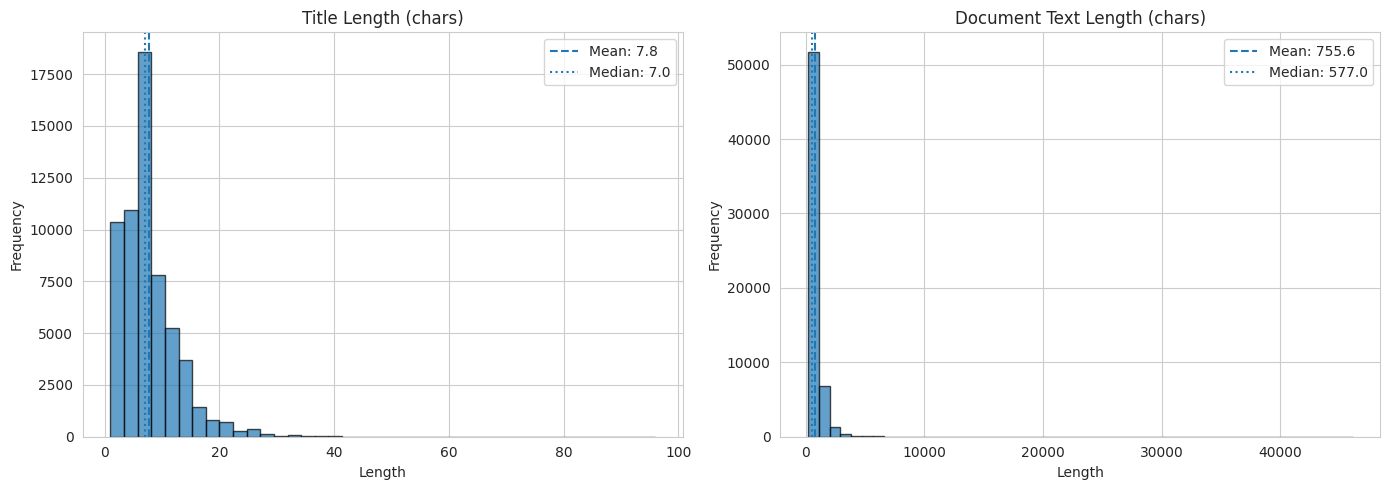

,통계,korean_ratio,kor_num_only_ratio
0,평균,0.63,0.88
1,중앙값,0.66,0.93
2,최소,0.00,0.00
3,최대,0.79,1.00


,doc_key,title,text,cleaned_text
35864,35864,우장산,『대동여지도』의 증산에 해당하는 매봉산 서북쪽으로 화곡동의 진산이다. 두 개의 봉우...,대동여지도 의 증산에 해당하는 매봉산 서북쪽으로 화곡동의 진산이다 두 개의 봉우리로...
37280,37280,경주 금척리 고분군,"경주 근교 금척리 평지에 있는 신라의 고분들로, 크고 작은 30여 기의 고분들이 모...",경주 근교 금척리 평지에 있는 신라의 고분들로 크고 작은 30여 기의 고분들이 모여...
56388,56388,미래를향한전진4.0,전진당은 우파가 궤멸된 이유를 세대 교체의 실패에서 찾는다. 현재 제1야당이라고 할...,전진당은 우파가 궤멸된 이유를 세대 교체의 실패에서 찾는다 현재 제1야당이라고 할 ...
16009,16009,박기석 (1869년),출신지는 원적지인 경상남도 진주군이나 평안남도 지역에서 활동하였다. 어릴 때 한학을...,출신지는 원적지인 경상남도 진주군이나 평안남도 지역에서 활동하였다 어릴 때 한학을 ...
35448,35448,고타 강령 비판,"《고타 강령 비판》(고타 綱領 批判, Kritik des Gothaer Progra...",고타 강령 비판 고타 은 1875년 5월 카를 마르크스가 독일의 사회민주주의 운동 ...


,값
평균 title 길이,7.78
평균 text 길이,754.07
평균 title/text 비율,0.01
중앙 title/text 비율,0.01
title이 본문에 그대로 포함된 비율,0.47


,doc_key,title,title_in_text,text
27244,27244,레러이,False,"여리의 세력이 날로 커져가는 가운데, 명나라의 왕통이 기습하여 만 여명이 참살당하는..."
10467,10467,울주 천전리 각석,False,"주로 신라 초기부터 통일신라에 이르기까지 조각되었다. 선긋기로 그어진 선들과 함께,..."
49951,49951,사창리 전투,False,중공군 제9병단은 1951년 4월 22일 춘계 공세 계획에 의거 국군 제6사단 방어...
42453,42453,2016년 태풍,False,2016년 제19호 태풍 에어리(AERE)는 10월 6일 오전 3시에 중심기압 10...
21234,21234,Awake (드림 시어터의 음반),False,트랙 4-6은 A Mind Beside Itself 모음곡의 세 파트를 구성하는 곡...


{'title_length_stats': {'컬럼': 'title', '평균': 7.8, '중앙값': 7.0, '최소': 1, '최대': 96, '표준편차': 4.82}, 'text_length_stats': {'컬럼': 'text', '평균': 755.57, '중앙값': 577.0, '최소': 184, '최대': 46099, '표준편차': 762.96}, 'korean_ratio_stats': [{'통계': '평균', 'korean_ratio': 0.629, 'kor_num_only_ratio': 0.883}, {'통계': '중앙값', 'korean_ratio': 0.659, 'kor_num_only_ratio': 0.926}, {'통계': '최소', 'korean_ratio': 0.0, 'kor_num_only_ratio': 0.0}, {'통계': '최대', 'korean_ratio': 0.791, 'kor_num_only_ratio': 0.997}]}


In [94]:
explorer = WikipediaCorpusExplorer(wiki_df)

# 1) 기본 정보 확인
explorer.basic_info()

# 2) 길이 통계 + 분포
display(explorer.length_stats())
explorer.plot_length_distributions()

# 3) 한글/숫자 비율 확인 + 전처리 미리보기
display(explorer.korean_char_ratio_stats())
display(explorer.preview_korean_filter(n=5, keep_english=False))

# 4) 타이틀 신호 분석
display(explorer.title_signal_stats())
display(explorer.show_title_body_examples(n=5, only_not_in_text=True))

# 5) MRC 관점 요약 값만 딱 보고 싶을 때
summary = explorer.mrc_retrieval_summary()
print(summary)


In [95]:
# TODO: 전처리 아이디어: title에 아무 의미없는 노이즈는 없지만 초성 ㅈ, ㅇ, 그리스 문자등은 행제거하는게 나을 수도 있어 보임
# 정답까지 분석 후 진행

wiki_df[wiki_df["title"].str.len() <= 1].sample(30)

,doc_key,text,corpus_source,url,domain,title,author,html,document_id
895,895,록필댐(rock-filled dam)은 조립질의 재료를 다져 만드는 댐이다. 재료를...,위키피디아,TODO,None,댐,None,None,895
12497,12497,욥이 살았던 시대의 연대를 정확히 산정하기란 쉬운 일이 아니다. 왜냐하면 책 안에 ...,위키피디아,None,None,욥,None,None,12497
19449,19449,위키백과:표|설명=위키백과의 표에 대해서는\n \n표(表) 또는 테이블(table)...,위키피디아,None,None,표,None,None,19449
19450,19450,"대다수의 기본적인 형태의 표에 대한 매우 간략하게 설명하자면, 표는 정연하게 정렬된...",위키피디아,None,None,표,None,None,19450
1881,1881,"아랍인들이 이슬람 제국을 건국하면서 이슬람교가 전파됐고, 사산조 멸망 이후는 샤 칭...",위키피디아,TODO,None,샤,None,None,1881
896,896,흙댐(earth-filled dam)은 흙을 잘 다져 쌓은 댐이다. 흙댐에는 존형(...,위키피디아,TODO,None,댐,None,None,896
12862,12862,팬\n \n펜(pen)은 종이 등에 잉크를 묻혀 글씨를 쓰거나 그림을 그리는 필기구...,위키피디아,None,None,펜,None,None,12862
2107,2107,"황을 불태우면 이산화 황(SO)이 되면서 푸른 불꽃을 내며 탄다. 이때, 부식성이 ...",위키피디아,TODO,None,황,None,None,2107
897,897,아치댐\n아치댐은 자중에 의한 중력과 아치효과에 의해 안정성을 확보하는 형식의 댐이...,위키피디아,TODO,None,댐,None,None,897
10107,10107,실의 굵기는 실의 지름으로 나타내지 않고 길이와 무게와의 관계로 나타낸다. 일정한 ...,위키피디아,None,None,실,None,None,10107


## 7. 정답(Answer) 위치 및 특성 분석

In [96]:
def analyze_answer_characteristics(train_df, valid_df):
    """
    Train/Validation 데이터의 정답 위치 및 특성 분석
    """
    print("\n" + "=" * 70)
    print("✅ 정답(Answer) 위치 및 특성 분석")
    print("=" * 70)

    # ===== Train 데이터 =====
    print("\n📊 TRAIN 데이터셋:")
    print("-" * 70)

    # train_df = train_data.to_pandas()

    # 정답 길이
    answer_lengths_train = []
    for ans_dict in train_df["answers"]:
        if isinstance(ans_dict, dict) and ans_dict.get("text"):
            for ans_text in ans_dict["text"]:
                answer_lengths_train.append(len(ans_text))

    print(f"\n📏 정답 길이 통계:")
    print(f"  - 총 정답 개수: {len(answer_lengths_train):,}")
    print(f"  - 평균: {np.mean(answer_lengths_train):.2f}자")
    print(f"  - 중앙값: {np.median(answer_lengths_train):.2f}자")
    print(f"  - 표준편차: {np.std(answer_lengths_train):.2f}자")
    print(
        f"  - 범위: {min(answer_lengths_train):.0f} ~ {max(answer_lengths_train):.0f}자"
    )

    # 정답 위치 (context 내에서의 상대 위치)
    answer_positions_train = []
    for idx, row in train_df.iterrows():
        if row["answers"]["answer_start"]:
            context_len = len(row["context"])
            for ans_start in row["answers"]["answer_start"]:
                pos_ratio = (ans_start / context_len) * 100 if context_len > 0 else 0
                answer_positions_train.append(pos_ratio)

    print(f"\n📍 정답 위치 분석 (Context 내 상대 위치):")
    print(f"  - 총 정답 샘플: {len(answer_positions_train):,}")
    print(f"  - 평균 위치: {np.mean(answer_positions_train):.1f}% (0=처음, 100=끝)")
    print(f"  - 중앙값 위치: {np.median(answer_positions_train):.1f}%")
    print(f"  - 표준편차: {np.std(answer_positions_train):.1f}%")

    # 정답 개수 분포
    answer_count_dist_train = (
        train_df["answers"].apply(lambda x: len(x["text"])).value_counts().sort_index()
    )
    print(f"\n🔢 샘플당 정답 개수 분포:")
    for count, freq in answer_count_dist_train.items():
        pct = (freq / len(train_df)) * 100
        print(f"  - {count}개: {freq:,}개 ({pct:.1f}%)")

    # ===== Valid 데이터 =====
    print(f"\n📊 VALIDATION 데이터셋:")
    print("-" * 70)

    # valid_df = valid_data.to_pandas()

    # 정답 길이
    answer_lengths_valid = []
    for ans_dict in valid_df["answers"]:
        if isinstance(ans_dict, dict) and ans_dict.get("text"):
            for ans_text in ans_dict["text"]:
                answer_lengths_valid.append(len(ans_text))

    print(f"\n📏 정답 길이 통계:")
    print(f"  - 총 정답 개수: {len(answer_lengths_valid):,}")
    print(f"  - 평균: {np.mean(answer_lengths_valid):.2f}자")
    print(f"  - 중앙값: {np.median(answer_lengths_valid):.2f}자")
    print(f"  - 표준편차: {np.std(answer_lengths_valid):.2f}자")
    print(
        f"  - 범위: {min(answer_lengths_valid):.0f} ~ {max(answer_lengths_valid):.0f}자"
    )

    # 정답 위치
    answer_positions_valid = []
    for idx, row in valid_df.iterrows():
        if row["answers"]["answer_start"]:
            context_len = len(row["context"])
            for ans_start in row["answers"]["answer_start"]:
                pos_ratio = (ans_start / context_len) * 100 if context_len > 0 else 0
                answer_positions_valid.append(pos_ratio)

    print(f"\n📍 정답 위치 분석 (Context 내 상대 위치):")
    print(f"  - 총 정답 샘플: {len(answer_positions_valid):,}")
    print(f"  - 평균 위치: {np.mean(answer_positions_valid):.1f}% (0=처음, 100=끝)")
    print(f"  - 중앙값 위치: {np.median(answer_positions_valid):.1f}%")
    print(f"  - 표준편차: {np.std(answer_positions_valid):.1f}%")

    # 정답 개수 분포
    answer_count_dist_valid = (
        valid_df["answers"].apply(lambda x: len(x["text"])).value_counts().sort_index()
    )
    print(f"\n🔢 샘플당 정답 개수 분포:")
    for count, freq in answer_count_dist_valid.items():
        pct = (freq / len(valid_df)) * 100
        print(f"  - {count}개: {freq:,}개 ({pct:.1f}%)")

    return {
        "train_lengths": answer_lengths_train,
        "train_positions": answer_positions_train,
        "valid_lengths": answer_lengths_valid,
        "valid_positions": answer_positions_valid,
    }


# 정답 분석 수행
answer_stats = analyze_answer_characteristics(train_df, valid_df)


✅ 정답(Answer) 위치 및 특성 분석

📊 TRAIN 데이터셋:
----------------------------------------------------------------------

📏 정답 길이 통계:
  - 총 정답 개수: 3,952
  - 평균: 6.28자
  - 중앙값: 5.00자
  - 표준편차: 5.35자
  - 범위: 1 ~ 83자

📍 정답 위치 분석 (Context 내 상대 위치):
  - 총 정답 샘플: 3,883
  - 평균 위치: 42.2% (0=처음, 100=끝)
  - 중앙값 위치: 38.3%
  - 표준편차: 28.0%

🔢 샘플당 정답 개수 분포:
  - 1개: 3,952개 (100.0%)

📊 VALIDATION 데이터셋:
----------------------------------------------------------------------

📏 정답 길이 통계:
  - 총 정답 개수: 240
  - 평균: 6.91자
  - 중앙값: 5.00자
  - 표준편차: 6.84자
  - 범위: 1 ~ 64자

📍 정답 위치 분석 (Context 내 상대 위치):
  - 총 정답 샘플: 235
  - 평균 위치: 44.1% (0=처음, 100=끝)
  - 중앙값 위치: 42.3%
  - 표준편차: 28.1%

🔢 샘플당 정답 개수 분포:
  - 1개: 240개 (100.0%)


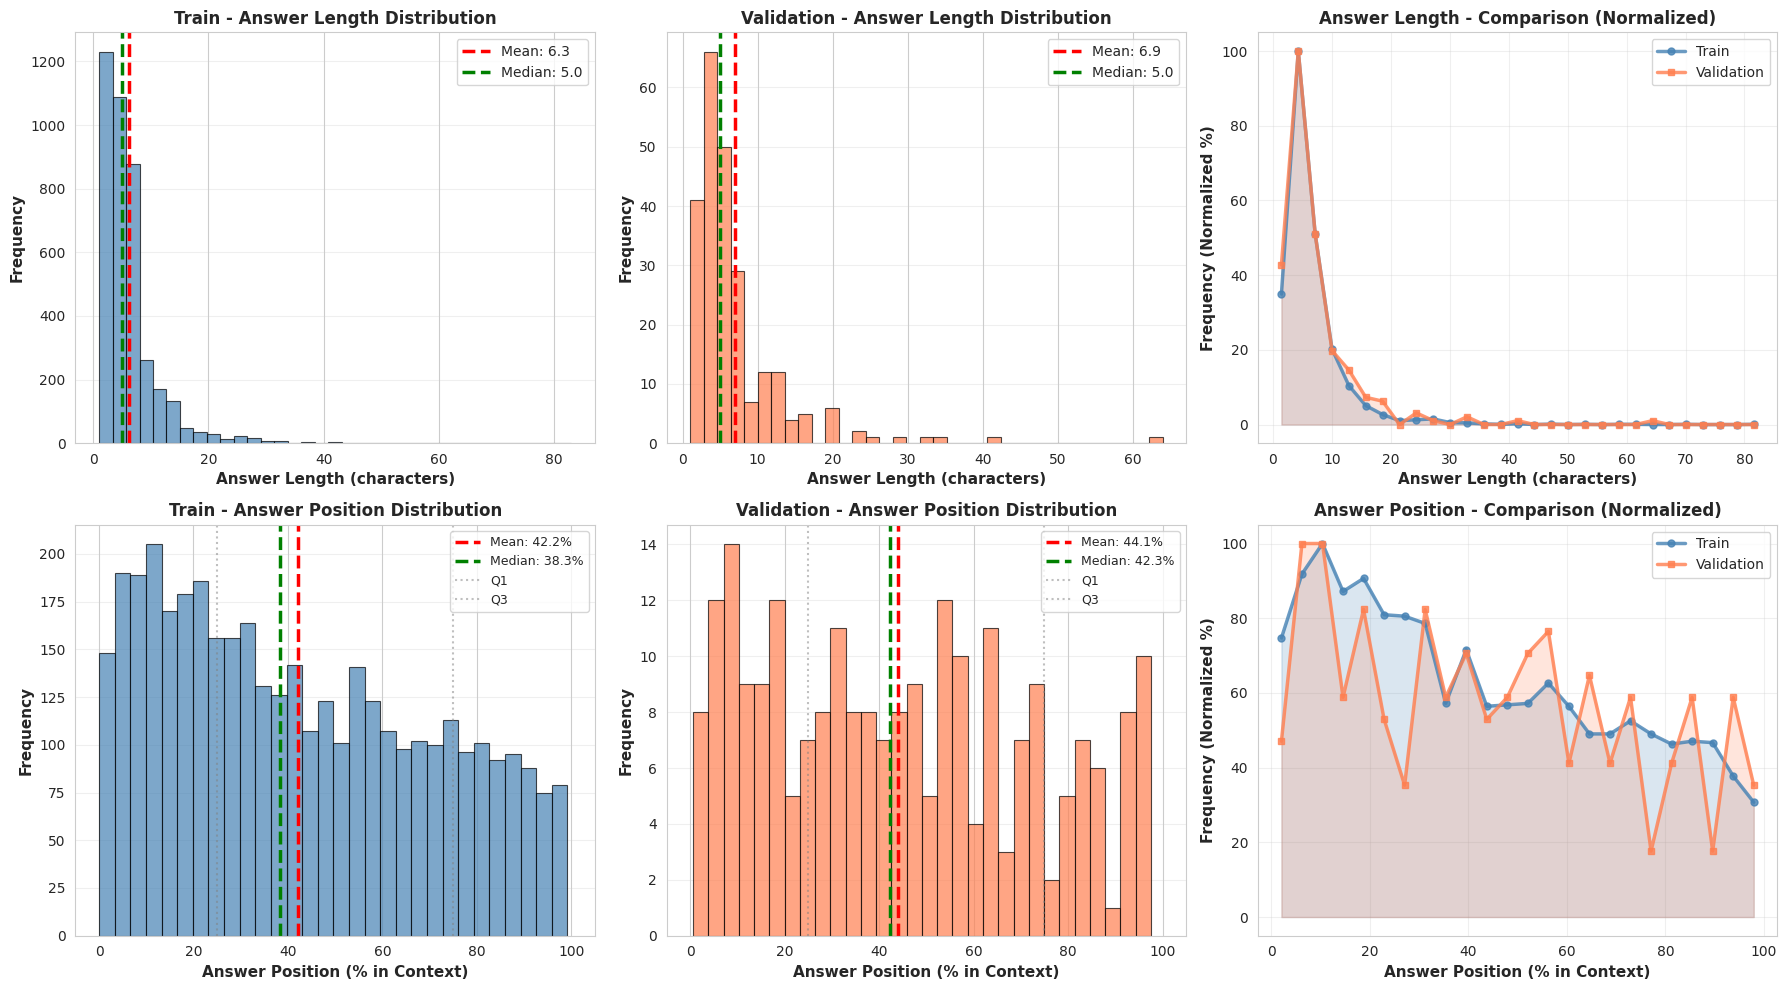

In [97]:
def visualize_answer_analysis(answer_stats):
    """
    정답 특성 시각화
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    train_lengths = answer_stats["train_lengths"]
    train_positions = answer_stats["train_positions"]
    valid_lengths = answer_stats["valid_lengths"]
    valid_positions = answer_stats["valid_positions"]

    # ===== Row 1: 정답 길이 분포 =====
    # Train 정답 길이
    ax = axes[0, 0]
    ax.hist(
        train_lengths,
        bins=35,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
    )
    ax.axvline(
        np.mean(train_lengths),
        color="red",
        linestyle="--",
        linewidth=2.5,
        label=f"Mean: {np.mean(train_lengths):.1f}",
    )
    ax.axvline(
        np.median(train_lengths),
        color="green",
        linestyle="--",
        linewidth=2.5,
        label=f"Median: {np.median(train_lengths):.1f}",
    )
    ax.set_xlabel("Answer Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title("Train - Answer Length Distribution", fontsize=12, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(axis="y", alpha=0.3)

    # Valid 정답 길이
    ax = axes[0, 1]
    ax.hist(
        valid_lengths,
        bins=35,
        color="coral",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
    )
    ax.axvline(
        np.mean(valid_lengths),
        color="red",
        linestyle="--",
        linewidth=2.5,
        label=f"Mean: {np.mean(valid_lengths):.1f}",
    )
    ax.axvline(
        np.median(valid_lengths),
        color="green",
        linestyle="--",
        linewidth=2.5,
        label=f"Median: {np.median(valid_lengths):.1f}",
    )
    ax.set_xlabel("Answer Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title(
        "Validation - Answer Length Distribution", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=10)
    ax.grid(axis="y", alpha=0.3)

    # 정답 길이 비교 (라인 그래프)
    ax = axes[0, 2]
    bins = np.linspace(0, max(max(train_lengths), max(valid_lengths)), 30)
    train_hist, bin_edges = np.histogram(train_lengths, bins=bins)
    valid_hist, _ = np.histogram(valid_lengths, bins=bins)

    train_norm = (train_hist / train_hist.max()) * 100
    valid_norm = (valid_hist / valid_hist.max()) * 100

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(
        bin_centers,
        train_norm,
        marker="o",
        linewidth=2.5,
        markersize=5,
        label="Train",
        color="steelblue",
        alpha=0.8,
    )
    ax.plot(
        bin_centers,
        valid_norm,
        marker="s",
        linewidth=2.5,
        markersize=5,
        label="Validation",
        color="coral",
        alpha=0.8,
    )
    ax.fill_between(bin_centers, train_norm, alpha=0.2, color="steelblue")
    ax.fill_between(bin_centers, valid_norm, alpha=0.2, color="coral")
    ax.set_xlabel("Answer Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Answer Length - Comparison (Normalized)", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=10)
    ax.grid(axis="both", alpha=0.3)

    # ===== Row 2: 정답 위치 분포 =====
    # Train 정답 위치
    ax = axes[1, 0]
    ax.hist(
        train_positions,
        bins=30,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
    )
    ax.axvline(
        np.mean(train_positions),
        color="red",
        linestyle="--",
        linewidth=2.5,
        label=f"Mean: {np.mean(train_positions):.1f}%",
    )
    ax.axvline(
        np.median(train_positions),
        color="green",
        linestyle="--",
        linewidth=2.5,
        label=f"Median: {np.median(train_positions):.1f}%",
    )
    ax.axvline(25, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q1")
    ax.axvline(75, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q3")
    ax.set_xlabel("Answer Position (% in Context)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title("Train - Answer Position Distribution", fontsize=12, fontweight="bold")
    ax.set_xlim(-5, 105)
    ax.legend(fontsize=9, loc="upper right")
    ax.grid(axis="y", alpha=0.3)

    # Valid 정답 위치
    ax = axes[1, 1]
    ax.hist(
        valid_positions,
        bins=30,
        color="coral",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
    )
    ax.axvline(
        np.mean(valid_positions),
        color="red",
        linestyle="--",
        linewidth=2.5,
        label=f"Mean: {np.mean(valid_positions):.1f}%",
    )
    ax.axvline(
        np.median(valid_positions),
        color="green",
        linestyle="--",
        linewidth=2.5,
        label=f"Median: {np.median(valid_positions):.1f}%",
    )
    ax.axvline(25, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q1")
    ax.axvline(75, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q3")
    ax.set_xlabel("Answer Position (% in Context)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title(
        "Validation - Answer Position Distribution", fontsize=12, fontweight="bold"
    )
    ax.set_xlim(-5, 105)
    ax.legend(fontsize=9, loc="upper right")
    ax.grid(axis="y", alpha=0.3)

    # 정답 위치 비교 (라인 그래프)
    ax = axes[1, 2]
    bins = np.linspace(0, 100, 25)
    train_pos_hist, bin_edges = np.histogram(train_positions, bins=bins)
    valid_pos_hist, _ = np.histogram(valid_positions, bins=bins)

    train_pos_norm = (train_pos_hist / train_pos_hist.max()) * 100
    valid_pos_norm = (valid_pos_hist / valid_pos_hist.max()) * 100

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(
        bin_centers,
        train_pos_norm,
        marker="o",
        linewidth=2.5,
        markersize=5,
        label="Train",
        color="steelblue",
        alpha=0.8,
    )
    ax.plot(
        bin_centers,
        valid_pos_norm,
        marker="s",
        linewidth=2.5,
        markersize=5,
        label="Validation",
        color="coral",
        alpha=0.8,
    )
    ax.fill_between(bin_centers, train_pos_norm, alpha=0.2, color="steelblue")
    ax.fill_between(bin_centers, valid_pos_norm, alpha=0.2, color="coral")
    ax.set_xlabel("Answer Position (% in Context)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Answer Position - Comparison (Normalized)", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=10)
    ax.grid(axis="both", alpha=0.3)

    plt.tight_layout()
    plt.show()


# 정답 분석 시각화
visualize_answer_analysis(answer_stats)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 0. 공용 유틸
# ------------------------------------------------------------
def make_adaptive_bins(lengths, fine_max: int = 10, coarse_step: int = 5):
    """
    Answer length 같은 값에 대해,
    - 0 ~ fine_max 까지는 1 단위로
    - 이후는 coarse_step 단위로
    bin을 잘게/굵게 섞어서 만드는 함수.
    """
    max_len = int(max(lengths)) if len(lengths) > 0 else fine_max
    fine_bins = np.arange(0, fine_max + 1, 1)
    if max_len <= fine_max:
        return fine_bins

    coarse_bins = np.arange(fine_max + coarse_step, max_len + coarse_step, coarse_step)
    return np.concatenate([fine_bins, coarse_bins])


def _iter_answers(df: pd.DataFrame):
    """
    내부용: DataFrame의 answers 컬럼을 한 줄씩 풀어서
    '정답 1개 = row 1개' 형태로 만들어주는 제너레이터.

    반환 항목(dict):
      - row_idx: 원본 df index
      - id: 샘플 id (있으면)
      - question: 질문 (있으면)
      - context: 컨텍스트 (있으면)
      - answer_text: 정답 문자열
      - answer_start: context 내 시작 인덱스 (없으면 None)
      - answer_len: 정답 길이(문자 수)
      - answer_pos_pct: context 내 상대 위치(%) (없으면 None)
    """
    for row_idx, row in df.iterrows():
        ans = row.get("answers", None)
        context = row.get("context", None)
        context_len = len(context) if isinstance(context, str) else None

        # HF 스타일: {"text": [...], "answer_start": [...]}
        texts = []
        starts = []

        if isinstance(ans, dict):
            texts = ans.get("text", []) or []
            starts = ans.get("answer_start", []) or []
        elif isinstance(ans, (list, tuple)):
            # 문자열 리스트라고 가정
            texts = list(ans)
            starts = [None] * len(texts)
        elif isinstance(ans, str):
            texts = [ans]
            starts = [None]
        else:
            continue  # 알 수 없는 타입은 스킵

        # 길이 mismatch 방어
        if len(starts) != len(texts):
            starts = [None] * len(texts)

        for text, start in zip(texts, starts):
            if text is None:
                continue
            text = str(text)
            answer_len = len(text)

            if context_len is not None and start is not None and context_len > 0:
                answer_pos_pct = (start / context_len) * 100
            else:
                answer_pos_pct = None

            yield {
                "row_idx": row_idx,
                "id": row.get("id", None),
                "question": row.get("question", None),
                "context": context,
                "answer_text": text,
                "answer_start": start,
                "answer_len": answer_len,
                "answer_pos_pct": answer_pos_pct,
            }


def _build_answer_detail_df(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    """
    한 DataFrame에 대해 '정답 1개 = 행 1개' 형태의 상세 DataFrame 생성.
    """
    records = []
    for rec in _iter_answers(df):
        rec["dataset"] = dataset_name
        # context는 너무 길 수 있으니, 앞부분만 자른 컬럼 추가
        ctx = rec.get("context", None)
        if isinstance(ctx, str):
            rec["context_head_120"] = ctx[:120]
        else:
            rec["context_head_120"] = None
        records.append(rec)

    if not records:
        return pd.DataFrame(
            columns=[
                "dataset",
                "row_idx",
                "id",
                "question",
                "context_head_120",
                "answer_text",
                "answer_start",
                "answer_len",
                "answer_pos_pct",
            ]
        )

    df_detail = pd.DataFrame.from_records(records)
    cols_order = [
        "dataset",
        "row_idx",
        "id",
        "question",
        "context_head_120",
        "answer_text",
        "answer_len",
        "answer_start",
        "answer_pos_pct",
    ]
    return df_detail[cols_order]


# ------------------------------------------------------------
# 1. 메인 분석 함수
# ------------------------------------------------------------
def analyze_answer_characteristics(
    train_df: pd.DataFrame,
    valid_df: pd.DataFrame,
    short_len_threshold: int = 2,
    long_len_quantile: float = 0.99,
):
    """
    Train/Validation 데이터의 정답 위치 및 특성 분석 + 노이즈 후보 탐지.

    - 정답 1개당 1행인 detail_df 생성
    - 길이 통계, 위치 통계, 샘플당 정답 개수 분포 출력
    - 너무 짧은/너무 긴 정답을 노이즈 후보로 집계하여 DataFrame으로 반환

    Returns:
        stats: dict
          - train_lengths, train_positions
          - valid_lengths, valid_positions
          - train_detail_df, valid_detail_df
          - train_short_len_df, valid_short_len_df
          - train_long_len_df,  valid_long_len_df
          - config (threshold 정보)
    """
    print("\n" + "=" * 70)
    print("✅ 정답(Answer) 위치 및 특성 분석")
    print("=" * 70)

    # 0. 상세 DF 생성 (정답 1개 = 1행)
    train_detail_df = _build_answer_detail_df(train_df, dataset_name="train")
    valid_detail_df = _build_answer_detail_df(valid_df, dataset_name="valid")

    # ---------------- Train ----------------
    print("\n📊 TRAIN 데이터셋:")
    print("-" * 70)

    train_lengths = train_detail_df["answer_len"].tolist()
    train_positions = train_detail_df["answer_pos_pct"].dropna().tolist()

    print("\n📏 정답 길이 통계:")
    print(f"  - 총 정답 개수: {len(train_lengths):,}")
    print(f"  - 평균: {np.mean(train_lengths):.2f}자")
    print(f"  - 중앙값: {np.median(train_lengths):.2f}자")
    print(f"  - 표준편차: {np.std(train_lengths):.2f}자")
    print(f"  - 범위: {np.min(train_lengths):.0f} ~ {np.max(train_lengths):.0f}자")

    print("\n📍 정답 위치 분석 (Context 내 상대 위치):")
    if train_positions:
        print(f"  - 총 정답 샘플: {len(train_positions):,}")
        print(f"  - 평균 위치: {np.mean(train_positions):.1f}% (0=처음, 100=끝)")
        print(f"  - 중앙값 위치: {np.median(train_positions):.1f}%")
        print(f"  - 표준편차: {np.std(train_positions):.1f}%")
    else:
        print("  - 위치 정보(answer_start/context)가 없습니다.")

    # 샘플당 정답 개수 분포 (원본 df 기준)
    answer_count_dist_train = (
        train_df["answers"]
        .apply(lambda x: len(x.get("text", [])) if isinstance(x, dict) else 0)
        .value_counts()
        .sort_index()
    )
    print("\n🔢 샘플당 정답 개수 분포:")
    for count, freq in answer_count_dist_train.items():
        pct = (freq / len(train_df)) * 100
        print(f"  - {count}개: {freq:,}개 ({pct:.1f}%)")

    # ---------------- Valid ----------------
    print("\n📊 VALIDATION 데이터셋:")
    print("-" * 70)

    valid_lengths = valid_detail_df["answer_len"].tolist()
    valid_positions = valid_detail_df["answer_pos_pct"].dropna().tolist()

    print("\n📏 정답 길이 통계:")
    print(f"  - 총 정답 개수: {len(valid_lengths):,}")
    print(f"  - 평균: {np.mean(valid_lengths):.2f}자")
    print(f"  - 중앙값: {np.median(valid_lengths):.2f}자")
    print(f"  - 표준편차: {np.std(valid_lengths):.2f}자")
    print(f"  - 범위: {np.min(valid_lengths):.0f} ~ {np.max(valid_lengths):.0f}자")

    print("\n📍 정답 위치 분석 (Context 내 상대 위치):")
    if valid_positions:
        print(f"  - 총 정답 샘플: {len(valid_positions):,}")
        print(f"  - 평균 위치: {np.mean(valid_positions):.1f}% (0=처음, 100=끝)")
        print(f"  - 중앙값 위치: {np.median(valid_positions):.1f}%")
        print(f"  - 표준편차: {np.std(valid_positions):.1f}%")
    else:
        print("  - 위치 정보(answer_start/context)가 없습니다.")

    answer_count_dist_valid = (
        valid_df["answers"]
        .apply(lambda x: len(x.get("text", [])) if isinstance(x, dict) else 0)
        .value_counts()
        .sort_index()
    )
    print("\n🔢 샘플당 정답 개수 분포:")
    for count, freq in answer_count_dist_valid.items():
        pct = (freq / len(valid_df)) * 100
        print(f"  - {count}개: {freq:,}개 ({pct:.1f}%)")

    # ---------------- 노이즈 후보 탐지 ----------------
    print("\n" + "=" * 70)
    print("🧹 잠재적 노이즈 정답(너무 짧거나/너무 긴 정답) 탐지")
    print("=" * 70)

    all_lengths = np.array(train_lengths + valid_lengths)
    long_len_cut = np.quantile(all_lengths, long_len_quantile)

    # (1) 너무 짧은 정답
    train_short_len_df = train_detail_df[
        train_detail_df["answer_len"] <= short_len_threshold
    ].copy()
    valid_short_len_df = valid_detail_df[
        valid_detail_df["answer_len"] <= short_len_threshold
    ].copy()

    print(f"\n📉 너무 짧은 정답 (≤ {short_len_threshold}자) 후보:")
    print(
        f"  - Train: {len(train_short_len_df):,}개 / {len(train_detail_df):,}개 "
        f"({len(train_short_len_df) / max(len(train_detail_df),1) * 100:.2f}%)"
    )
    print(
        f"  - Valid: {len(valid_short_len_df):,}개 / {len(valid_detail_df):,}개 "
        f"({len(valid_short_len_df) / max(len(valid_detail_df),1) * 100:.2f}%)"
    )

    # (2) 너무 긴 정답
    train_long_len_df = train_detail_df[
        train_detail_df["answer_len"] >= long_len_cut
    ].copy()
    valid_long_len_df = valid_detail_df[
        valid_detail_df["answer_len"] >= long_len_cut
    ].copy()

    print(
        f"\n📈 너무 긴 정답 (상위 {int(long_len_quantile * 100)}% 구간, "
        f"≥ {long_len_cut:.1f}자) 후보:"
    )
    print(
        f"  - Train: {len(train_long_len_df):,}개 / {len(train_detail_df):,}개 "
        f"({len(train_long_len_df) / max(len(train_detail_df),1) * 100:.2f}%)"
    )
    print(
        f"  - Valid: {len(valid_long_len_df):,}개 / {len(valid_detail_df):,}개 "
        f"({len(valid_long_len_df) / max(len(valid_detail_df),1) * 100:.2f}%)"
    )

    # 간단 예시 몇 개만 바로 확인할 수 있게 출력
    if not train_short_len_df.empty:
        print("\n[Train] 너무 짧은 정답 예시 (상위 5개):")
        print(
            train_short_len_df[
                ["id", "answer_len", "answer_text", "context_head_120"]
            ]
            .head(5)
            .to_string(index=False)
        )
    if not train_long_len_df.empty:
        print("\n[Train] 너무 긴 정답 예시 (상위 5개):")
        print(
            train_long_len_df[
                ["id", "answer_len", "answer_text", "context_head_120"]
            ]
            .head(5)
            .to_string(index=False)
        )

    print(
        "\n👉 위 노이즈 후보들은 반환되는 DataFrame(train/valid_short_len_df, "
        "train/valid_long_len_df)을 직접 살펴보면서 필터링 전략을 세우면 좋습니다."
    )

    stats = {
        # 시각화용 기본 리스트
        "train_lengths": train_lengths,
        "train_positions": train_positions,
        "valid_lengths": valid_lengths,
        "valid_positions": valid_positions,
        # 상세 DF
        "train_detail_df": train_detail_df,
        "valid_detail_df": valid_detail_df,
        # 길이 기반 노이즈 후보
        "train_short_len_df": train_short_len_df,
        "valid_short_len_df": valid_short_len_df,
        "train_long_len_df": train_long_len_df,
        "valid_long_len_df": valid_long_len_df,
        # 설정 값
        "config": {
            "short_len_threshold": short_len_threshold,
            "long_len_quantile": long_len_quantile,
            "long_len_cut": float(long_len_cut),
        },
    }
    return stats


# ------------------------------------------------------------
# 2. 시각화 함수
# ------------------------------------------------------------
def visualize_answer_analysis(answer_stats):
    """
    정답 특성 시각화 (길이 + 위치, Train vs Valid 비교)
    """
    train_lengths = answer_stats["train_lengths"]
    train_positions = answer_stats["train_positions"]
    valid_lengths = answer_stats["valid_lengths"]
    valid_positions = answer_stats["valid_positions"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # ---------- Row 1: 정답 길이 분포 ----------
    # 1-1. Train 정답 길이
    ax = axes[0, 0]
    bins_len = make_adaptive_bins(train_lengths, fine_max=10, coarse_step=5)
    ax.hist(
        train_lengths,
        bins=bins_len,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
    )
    ax.axvline(
        np.mean(train_lengths),
        color="red",
        linestyle="--",
        linewidth=2.0,
        label=f"Mean: {np.mean(train_lengths):.1f}",
    )
    ax.axvline(
        np.median(train_lengths),
        color="green",
        linestyle="--",
        linewidth=2.0,
        label=f"Median: {np.median(train_lengths):.1f}",
    )
    ax.set_xlabel("Answer Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title("Train - Answer Length Distribution", fontsize=12, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(axis="y", alpha=0.3)

    # 1-2. Valid 정답 길이
    ax = axes[0, 1]
    bins_len_valid = make_adaptive_bins(valid_lengths, fine_max=10, coarse_step=5)
    ax.hist(
        valid_lengths,
        bins=bins_len_valid,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
    )
    ax.axvline(
        np.mean(valid_lengths),
        color="red",
        linestyle="--",
        linewidth=2.0,
        label=f"Mean: {np.mean(valid_lengths):.1f}",
    )
    ax.axvline(
        np.median(valid_lengths),
        color="green",
        linestyle="--",
        linewidth=2.0,
        label=f"Median: {np.median(valid_lengths):.1f}",
    )
    ax.set_xlabel("Answer Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title(
        "Validation - Answer Length Distribution", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=10)
    ax.grid(axis="y", alpha=0.3)

    # 1-3. 정답 길이 비교 (라인 그래프, 정규화)
    ax = axes[0, 2]
    all_lengths = train_lengths + valid_lengths
    bins_comp = make_adaptive_bins(all_lengths, fine_max=10, coarse_step=5)
    train_hist, bin_edges = np.histogram(train_lengths, bins=bins_comp)
    valid_hist, _ = np.histogram(valid_lengths, bins=bins_comp)

    # 0 나누기 방지
    train_max = train_hist.max() if train_hist.max() > 0 else 1
    valid_max = valid_hist.max() if valid_hist.max() > 0 else 1

    train_norm = (train_hist / train_max) * 100
    valid_norm = (valid_hist / valid_max) * 100

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(
        bin_centers,
        train_norm,
        marker="o",
        linewidth=2.0,
        markersize=4,
        label="Train",
        alpha=0.8,
    )
    ax.plot(
        bin_centers,
        valid_norm,
        marker="s",
        linewidth=2.0,
        markersize=4,
        label="Validation",
        alpha=0.8,
    )
    ax.fill_between(bin_centers, train_norm, alpha=0.2)
    ax.fill_between(bin_centers, valid_norm, alpha=0.2)
    ax.set_xlabel("Answer Length (characters)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Answer Length - Comparison (Normalized)", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=10)
    ax.grid(axis="both", alpha=0.3)

    # ---------- Row 2: 정답 위치 분포 ----------
    # 위치 정보가 없으면 아래 그래프는 빈 상태로 안내 문구만 출력
    # 2-1. Train 정답 위치
    ax = axes[1, 0]
    if len(train_positions) > 0:
        ax.hist(
            train_positions,
            bins=30,
            alpha=0.7,
            edgecolor="black",
            linewidth=0.8,
        )
        ax.axvline(
            np.mean(train_positions),
            color="red",
            linestyle="--",
            linewidth=2.0,
            label=f"Mean: {np.mean(train_positions):.1f}%",
        )
        ax.axvline(
            np.median(train_positions),
            color="green",
            linestyle="--",
            linewidth=2.0,
            label=f"Median: {np.median(train_positions):.1f}%",
        )
        ax.axvline(25, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q1")
        ax.axvline(75, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q3")
        ax.set_xlim(-5, 105)
        ax.legend(fontsize=9, loc="upper right")
    else:
        ax.text(
            0.5,
            0.5,
            "No answer_start/context\ninformation",
            ha="center",
            va="center",
            fontsize=11,
            transform=ax.transAxes,
        )
    ax.set_xlabel("Answer Position (% in Context)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title("Train - Answer Position Distribution", fontsize=12, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)

    # 2-2. Valid 정답 위치
    ax = axes[1, 1]
    if len(valid_positions) > 0:
        ax.hist(
            valid_positions,
            bins=30,
            alpha=0.7,
            edgecolor="black",
            linewidth=0.8,
        )
        ax.axvline(
            np.mean(valid_positions),
            color="red",
            linestyle="--",
            linewidth=2.0,
            label=f"Mean: {np.mean(valid_positions):.1f}%",
        )
        ax.axvline(
            np.median(valid_positions),
            color="green",
            linestyle="--",
            linewidth=2.0,
            label=f"Median: {np.median(valid_positions):.1f}%",
        )
        ax.axvline(25, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q1")
        ax.axvline(75, color="gray", linestyle=":", linewidth=1.5, alpha=0.5, label="Q3")
        ax.set_xlim(-5, 105)
        ax.legend(fontsize=9, loc="upper right")
    else:
        ax.text(
            0.5,
            0.5,
            "No answer_start/context\ninformation",
            ha="center",
            va="center",
            fontsize=11,
            transform=ax.transAxes,
        )
    ax.set_xlabel("Answer Position (% in Context)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
    ax.set_title(
        "Validation - Answer Position Distribution", fontsize=12, fontweight="bold"
    )
    ax.grid(axis="y", alpha=0.3)

    # 2-3. 정답 위치 비교 (정규화 라인 그래프)
    ax = axes[1, 2]
    if len(train_positions) > 0 and len(valid_positions) > 0:
        bins_pos = np.linspace(0, 100, 25)
        train_pos_hist, bin_edges = np.histogram(train_positions, bins=bins_pos)
        valid_pos_hist, _ = np.histogram(valid_positions, bins=bins_pos)

        train_pos_max = train_pos_hist.max() if train_pos_hist.max() > 0 else 1
        valid_pos_max = valid_pos_hist.max() if valid_pos_hist.max() > 0 else 1

        train_pos_norm = (train_pos_hist / train_pos_max) * 100
        valid_pos_norm = (valid_pos_hist / valid_pos_max) * 100

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.plot(
            bin_centers,
            train_pos_norm,
            marker="o",
            linewidth=2.0,
            markersize=4,
            label="Train",
            alpha=0.8,
        )
        ax.plot(
            bin_centers,
            valid_pos_norm,
            marker="s",
            linewidth=2.0,
            markersize=4,
            label="Validation",
            alpha=0.8,
        )
        ax.fill_between(bin_centers, train_pos_norm, alpha=0.2)
        ax.fill_between(bin_centers, valid_pos_norm, alpha=0.2)
        ax.set_xlim(-5, 105)
        ax.legend(fontsize=10)
    else:
        ax.text(
            0.5,
            0.5,
            "Not enough position info\nfor comparison",
            ha="center",
            va="center",
            fontsize=11,
            transform=ax.transAxes,
        )

    ax.set_xlabel("Answer Position (% in Context)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Frequency (Normalized %)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Answer Position - Comparison (Normalized)", fontsize=12, fontweight="bold"
    )
    ax.grid(axis="both", alpha=0.3)

    plt.tight_layout()
    plt.show()



✅ 정답(Answer) 위치 및 특성 분석

📊 TRAIN 데이터셋:
----------------------------------------------------------------------

📏 정답 길이 통계:
  - 총 정답 개수: 3,952
  - 평균: 6.28자
  - 중앙값: 5.00자
  - 표준편차: 5.35자
  - 범위: 1 ~ 83자

📍 정답 위치 분석 (Context 내 상대 위치):
  - 총 정답 샘플: 3,883
  - 평균 위치: 42.2% (0=처음, 100=끝)
  - 중앙값 위치: 38.3%
  - 표준편차: 28.0%

🔢 샘플당 정답 개수 분포:
  - 1개: 3,952개 (100.0%)

📊 VALIDATION 데이터셋:
----------------------------------------------------------------------

📏 정답 길이 통계:
  - 총 정답 개수: 240
  - 평균: 6.91자
  - 중앙값: 5.00자
  - 표준편차: 6.84자
  - 범위: 1 ~ 64자

📍 정답 위치 분석 (Context 내 상대 위치):
  - 총 정답 샘플: 235
  - 평균 위치: 44.1% (0=처음, 100=끝)
  - 중앙값 위치: 42.3%
  - 표준편차: 28.1%

🔢 샘플당 정답 개수 분포:
  - 1개: 240개 (100.0%)

🧹 잠재적 노이즈 정답(너무 짧거나/너무 긴 정답) 탐지

📉 너무 짧은 정답 (≤ 2자) 후보:
  - Train: 600개 / 3,952개 (15.18%)
  - Valid: 41개 / 240개 (17.08%)

📈 너무 긴 정답 (상위 99% 구간, ≥ 28.0자) 후보:
  - Train: 39개 / 3,952개 (0.99%)
  - Valid: 5개 / 240개 (2.08%)

[Train] 너무 짧은 정답 예시 (상위 5개):
          id  answer_len answer_text                      

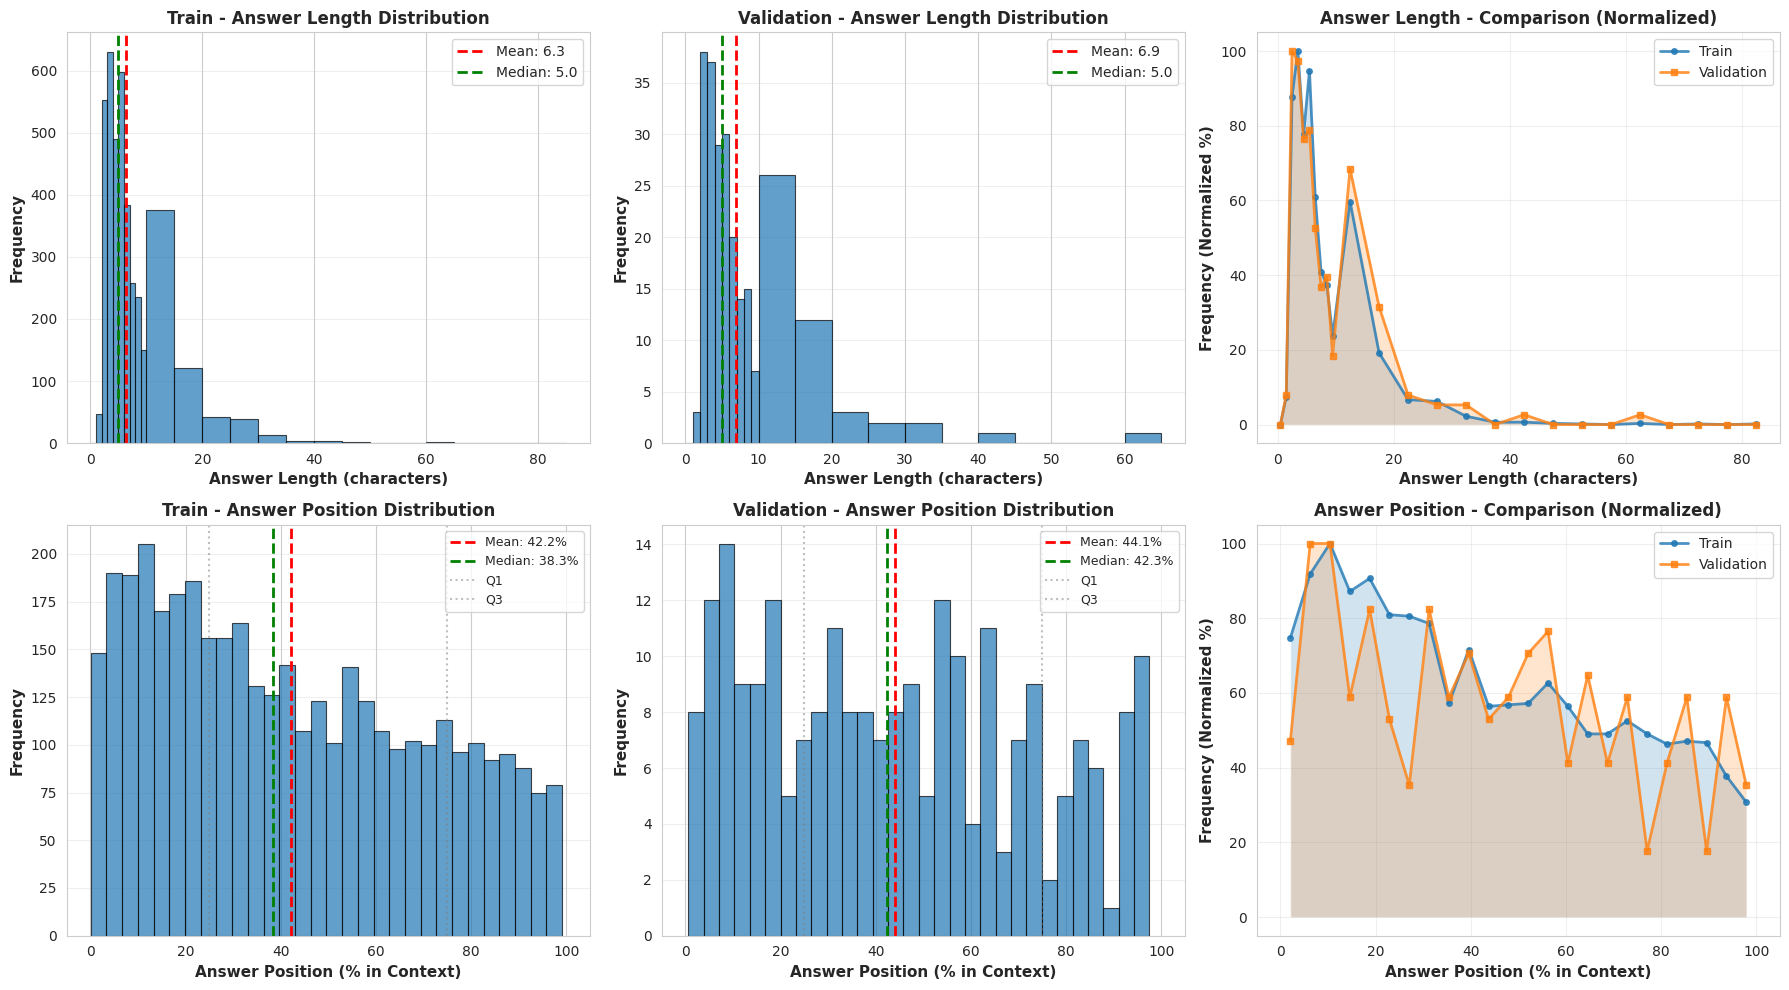

In [99]:
answer_stats = analyze_answer_characteristics(train_df, valid_df,
                                              short_len_threshold=2,
                                              long_len_quantile=0.99)

visualize_answer_analysis(answer_stats)

In [100]:
print("\n=== 너무 짧은 정답 후보 샘플 ===")
print(answer_stats["train_short_len_df"].shape)
display(answer_stats["train_short_len_df"].sample(10))
print("\n=== 너무 긴 정답 후보 샘플 ===")
print(answer_stats["train_long_len_df"].shape)
display(answer_stats["train_long_len_df"].sample(10))
print(answer_stats["config"])


=== 너무 짧은 정답 후보 샘플 ===
(600, 9)


,dataset,row_idx,id,question,context_head_120,answer_text,answer_len,answer_start,answer_pos_pct
3279,train,3279,mrc-1-001249,델핀이 젊은 남자와 같이 녹색 광선을 본 곳은?,영화는 델핀의 여름 휴가에서 시작한다. 같이 여행을 가기로 했던 친구가 델핀을 놔두...,해변,2,501.00,96.53
2415,train,2415,mrc-1-000538,미드웨이 해전에서 일본 항공모함은 몇 대 소실되었나?,"이세급 전함은 원래 일본 최초의 초노급전함인 후소급 전함의 3, 4번 함으로 계획되...",4척,2,513.00,62.71
1416,train,1416,mrc-0-001231,이를 빈약한 용이라 여긴 국가는 어디인가?,이(螭)는 중국 신화에 등장하는 용의 일종이다. 명나라의 백과전서인 《본초강목》에 ...,일본,2,560.00,76.40
1294,train,1294,mrc-0-003579,성제가 즉위하기 전의 왕은 누구인가?,진만년의 임자로 낭(郞)이 되었다. 재주가 있고 강직하여 여러 차례 권신들을 탄핵니...,원제,2,186.00,13.18
3846,train,3846,mrc-0-002233,하녀의 청을 받고 팔라다를 죽인 사람은?,옛날에 남편을 잃은 한 늙은 여왕이 살고있었다.여왕의 딸은 먼곳의 왕자와 약혼을하고...,왕자,2,356.00,32.57
637,train,637,mrc-0-000330,도쿄와 오사카를 연결하는 간설 철도로 주로 실어 나른 것은?,"오다카 역은 1886년 3월, 다케토요 역과 아쓰타 역을 연결하는 철도 노선의 중간...",자재,2,141.00,16.13
3686,train,3686,mrc-1-000866,가포 앞바다의 자연이 치료에 도움이 되는 병은?,"본래 합포현의 지역으로서, ‘밤구미’ 또는 ‘율구미’로 불리었는데, 율(栗)은 밤나...",결핵,2,431.00,75.09
1037,train,1037,mrc-1-000646,"탐색을 시작할 때, 제일 먼저 설치해야 하는 것은 무엇인가?",이 게임의 특징의 하나가 던전의 탐색이다. 탐색을 하려면 네 명의 기사를 선택하면 ...,술집,2,113.00,8.75
262,train,262,mrc-0-003799,인천에 이발소가 처음 생긴 해에 장면의 나이는?,이후 아버지의 근무지인 인천부 전동(典洞)으로 와서 살다가 1908년 인천부 인천항...,9세,2,168.00,19.33
604,train,604,mrc-0-005505,향교에 들어갈 수 있는 가장 낮은 신분은?,향교는 조선시대 국가에서 설립한 지방 교육기관으로 중·고등학교 수준의 교육을 담당하...,양민,2,50.00,9.67



=== 너무 긴 정답 후보 샘플 ===
(39, 9)


,dataset,row_idx,id,question,context_head_120,answer_text,answer_len,answer_start,answer_pos_pct
789,train,789,mrc-0-000111,두 개의 지역으로 줄어든 후에 킬리키아의 명칭은 무엇으로 변경되었나?,기원전 47년에 율리우스 카이사르는 킬리키아를 재편성했다. 키비라 (Cibyra) ...,시리아킬리키아 포에니케 (Syria-Cilicia Phoenice),37,462.00,48.02
790,train,790,mrc-0-002291,제2차 야마모토 내각이 국가가 직접 조선인을 감찰할 것이니 개인이 사적 제재를 하지...,혼조 사건 (1923년)\n간토 대지진 조선인 학살 사건\n \n지진 발생 이후 혼...,내각고유 제2호(조선인에 대한 박해와 관련된 사고 건),30,276.00,41.38
1089,train,1089,mrc-0-001276,포츠머스 조약에 따라 일본이 러시아로부터 받아낸 것은?,"히비야 방화 사건(히비야 야키우치 지켄)은 러일 전쟁 직후인 1905년 9월 5일,...",북위 50도 이남의 사할린 섬 및 조차지 요동 반도,28,130.00,20.34
3623,train,3623,mrc-0-002332,유명 작곡가들의 교향곡이 9번에서 끝난 것을 표현하는 말은?,"이 작품은 베토벤, 슈베르트, 슈포어, 드보르자크, 브루크너, 말러, 글라주노프 등...",제9번이 마지막 교향곡이 된다는 운명적 신화 (9번 교향곡의 저주),37,93.00,5.22
2801,train,2801,mrc-0-001942,율레스 레폰트가 디자인하기 직전 제복은 어디에서 볼 수 있는가?,"스위스 근위대의 공식 제복은 전형적인 르네상스풍으로 파랑색, 빨강색, 주황색, 노란...",‘교황 식스토 3세와 대화를 나누는 에우독시아 황후’,29,395.00,41.67
2963,train,2963,mrc-0-004008,마르크수 주의를 주장하는 사람들이 자본국가를 어떻게 지칭하는가?,"자본국가(資本國家, capitalist state)란 자본주의 사회경제체제에 따라 ...",“부르주아 독재(Dictatorship of the bourgeoisie)”,42,755.00,81.89
3658,train,3658,mrc-0-000934,고권삼이 친일인명사전 수록예정자 명단 중 해외 부문에 포함된 이유는 무엇 때문인가?,제주도 남제주군 출신이다. 1927년에 와세다 대학 정경학부를 졸업한 뒤 일본에 머...,황도철학이라는 어용 학문을 연구해 다수의 논설을 발표한 일,32,324.00,53.47
574,train,574,mrc-0-004213,도스토옙스키의 시력이 망가졌을 때 그는 어떤 방식으로 작품을 완성할 수 있었나?,"1861년 형과 함께 잡지 《시대》를 발간하고, 《학대받는 사람들》, 《죽음의 집 ...",도스토옙스키가 침대 누워 구술한 것을 아내 안나가 속기 하여,33,775.00,76.20
1704,train,1704,mrc-1-001830,작품 《트로일러스와 크리세이드》가 일으키는 논란을 해결하기 어렵다고 본 사람은?,셰익스피어의 《트로일러스와 크리세이드》는 공연 시기를 특정하는 문제와 함께 장르를 ...,프레드릭 S. 보아스 (Frederick S. Boas),31,91.00,10.17
1577,train,1577,mrc-1-001478,이중근이 서울지방검찰청 검사로 재직할 당시에 맡았던 사건은?,1935년 부산광역시에서 태어나 서울대학교 법학과를 졸업하고 1956년 제8회 고등...,열차 공안원들과 공모한 조직적인 열차 소매치기 사건,28,478.00,65.57


{'short_len_threshold': 2, 'long_len_quantile': 0.99, 'long_len_cut': 28.0}


In [101]:
def answer_length_quantiles(lengths, quantiles=(0.5, 0.75, 0.9, 0.95, 0.99)):
    """
    정답 길이 분포의 quantile 기준 요약

    Returns:
        pd.DataFrame
    """
    rows = []
    for q in quantiles:
        rows.append({
            "quantile": f"{int(q*100)}%",
            "answer_length": int(np.quantile(lengths, q))
        })

    return pd.DataFrame(rows)


In [102]:
# 인사이트! train answer 길이 15자 이내가 전체 95% 커버
# 90%이상 13자 정도 이내 정답만 만들면 커버 됨.
display(answer_length_quantiles(answer_stats["train_lengths"]))
display(answer_length_quantiles(answer_stats["valid_lengths"]))


,quantile,answer_length
0,50%,5
1,75%,8
2,90%,12
3,95%,15
4,99%,27


,quantile,answer_length
0,50%,5
1,75%,8
2,90%,13
3,95%,19
4,99%,33


TODO: questio에 string query 날려서 어떤 의문사가 자주 등장하는지 분석

## 9. 데이터셋을 텍스트/CSV 파일로 내보내기

전체 데이터를 파일로 저장하여 한번에 스캔 가능하게 함

In [103]:
def export_dataset_to_csv(dataset, output_path, max_context_length=None):
    """
    데이터셋을 CSV 파일로 내보내기

    Args:
        dataset: HuggingFace Dataset 또는 DataFrame
        output_path: 저장 경로
        max_context_length: CSV에서 context 최대 길이 (줄이지 않으려면 None)
    """
    if hasattr(dataset, "to_pandas"):
        df = dataset.to_pandas()
    elif isinstance(dataset, pd.DataFrame):
        df = dataset.copy()
    else:
        df = pd.DataFrame(dataset)

    # context 길이 제한 (CSV에서 보기 좋게)
    if max_context_length and "context" in df.columns:
        df["context"] = df["context"].str[:max_context_length].str.replace("\n", " | ")

    # answers를 문자열로 변환 (json이 아닌 경우)
    if "answers" in df.columns:
        df["answers"] = df["answers"].apply(
            lambda x: " | ".join(x["text"]) if isinstance(x, dict) else str(x)
        )

    df.to_csv(output_path, index=False, encoding="utf-8")
    print(f"✅ CSV saved: {output_path}")
    print(f"   Rows: {len(df):,}, Columns: {len(df.columns)}")


def export_dataset_to_txt(dataset, output_path, wrap_width=80):
    """
    데이터셋을 읽기 좋은 텍스트 파일로 내보내기

    Args:
        dataset: HuggingFace Dataset 또는 DataFrame
        output_path: 저장 경로
        wrap_width: 텍스트 줄바꿈 너비
    """
    from textwrap import fill

    if hasattr(dataset, "to_pandas"):
        df = dataset.to_pandas()
    elif isinstance(dataset, pd.DataFrame):
        df = dataset
    else:
        df = pd.DataFrame(dataset)

    with open(output_path, "w", encoding="utf-8") as f:
        for idx in range(len(df)):
            sample = df.iloc[idx]

            f.write("\n" + "=" * 80 + "\n")
            f.write(f"SAMPLE #{idx}\n")
            f.write("=" * 80 + "\n")

            # ID
            f.write(f"\nID: {sample['id']}\n")

            # Question
            f.write(f"\nQUESTION:\n")
            f.write(
                fill(
                    sample["question"],
                    width=wrap_width,
                    initial_indent="  ",
                    subsequent_indent="  ",
                )
                + "\n"
            )

            # Context (있는 경우)
            if "context" in sample:
                f.write(f"\nCONTEXT:\n")
                context_text = sample["context"]
                f.write(
                    fill(
                        context_text,
                        width=wrap_width,
                        initial_indent="  ",
                        subsequent_indent="  ",
                    )
                    + "\n"
                )

            # Title (있는 경우)
            if "title" in sample and sample["title"]:
                f.write(f"\nTITLE: {sample['title']}\n")

            # Answers (있는 경우)
            if "answers" in sample:
                f.write(f"\nANSWERS:\n")
                # DataFrame에서는 dict로 저장되어 있음
                if isinstance(sample["answers"], dict):
                    for i, (ans_text, ans_start) in enumerate(
                        zip(
                            sample["answers"]["text"], sample["answers"]["answer_start"]
                        ),
                        1,
                    ):
                        f.write(f"  [{i}] {ans_text} (start: {ans_start})\n")
                else:
                    f.write(f"  {sample['answers']}\n")

            # Document ID (있는 경우)
            if "document_id" in sample:
                f.write(f"\nDOCUMENT_ID: {sample['document_id']}\n")

    print(f"✅ TXT saved: {output_path}")
    print(f"   Total samples: {len(df):,}")


# 출력 디렉토리 생성
output_dir = Path("../outputs/eda_exports")
output_dir.mkdir(parents=True, exist_ok=True)

# 데이터셋 내보내기
print("📤 데이터셋을 파일로 내보내는 중...")

# Train 데이터
export_dataset_to_csv(
    train_df, output_dir / "train_dataset.csv", max_context_length=300
)
export_dataset_to_txt(train_df, output_dir / "train_dataset.txt")

print("\n")

# Validation 데이터
export_dataset_to_csv(
    valid_df, output_dir / "validation_dataset.csv", max_context_length=300
)
export_dataset_to_txt(valid_df, output_dir / "validation_dataset.txt")

print("\n")

# Test 데이터
export_dataset_to_csv(test_df, output_dir / "test_dataset.csv")
export_dataset_to_txt(test_df, output_dir / "test_dataset.txt")

print(f"\n✨ 모든 파일이 저장되었습니다: {output_dir.resolve()}")

📤 데이터셋을 파일로 내보내는 중...
✅ CSV saved: ../outputs/eda_exports/train_dataset.csv
   Rows: 3,952, Columns: 7
✅ TXT saved: ../outputs/eda_exports/train_dataset.txt
   Total samples: 3,952


✅ CSV saved: ../outputs/eda_exports/validation_dataset.csv
   Rows: 240, Columns: 7
✅ TXT saved: ../outputs/eda_exports/validation_dataset.txt
   Total samples: 240


✅ CSV saved: ../outputs/eda_exports/test_dataset.csv
   Rows: 600, Columns: 2
✅ TXT saved: ../outputs/eda_exports/test_dataset.txt
   Total samples: 600

✨ 모든 파일이 저장되었습니다: /data/ephemeral/home/shared/outputs/eda_exports


## 10. MRC 프로젝트 특화 분석

질문 응답 쌍의 특성, 정답 위치 분포, 난이도 평가 등

In [104]:
def analyze_mrc_characteristics(dataset, dataset_name="Dataset"):
    """
    MRC 데이터셋의 특성 분석

    Args:
        dataset: HuggingFace Dataset 또는 DataFrame
        dataset_name: 데이터셋 이름 (출력용)
    """
    print("\n" + "=" * 70)
    print(f"🎯 {dataset_name} - MRC 특성 분석")
    print("=" * 70)

    if hasattr(dataset, "to_pandas"):
        df = dataset.to_pandas()
    elif isinstance(dataset, pd.DataFrame):
        df = dataset
    else:
        df = pd.DataFrame(dataset)

    # 1. 정답 관련 분석
    if "answers" in df.columns:
        print("\n📍 정답 분석:")

        # 정답 개수 분포
        answer_counts = df["answers"].apply(lambda x: len(x["text"]))
        print(f"  - 샘플당 정답 개수 분포:")
        print(f"    {answer_counts.value_counts().sort_index().to_dict()}")
        print(f"  - 평균 정답 개수: {answer_counts.mean():.2f}")

        # 정답 길이 분석
        answer_lengths = df["answers"].apply(
            lambda x: np.mean([len(t) for t in x["text"]]) if x["text"] else 0
        )
        print(f"\n  - 정답 길이 통계:")
        print(f"    평균: {answer_lengths.mean():.1f} 자")
        print(f"    중앙값: {answer_lengths.median():.1f} 자")
        print(f"    최소: {answer_lengths.min():.1f} 자")
        print(f"    최대: {answer_lengths.max():.1f} 자")

        # 정답 위치 분석 (context 내에서의 위치)
        print(f"\n  - 정답 위치 분석 (context 내 위치 백분율):")
        answer_positions = []
        for idx, row in df.iterrows():
            if row["answers"]["answer_start"]:
                context_len = len(row["context"])
                pos_ratio = row["answers"]["answer_start"][0] / context_len * 100
                answer_positions.append(pos_ratio)

        if answer_positions:
            print(f"    평균 위치: {np.mean(answer_positions):.1f}%")
            print(f"    중앙값 위치: {np.median(answer_positions):.1f}%")

    # 2. 질문 특성 분석
    print(f"\n❓ 질문 특성 분석:")

    question_lengths = df["question"].str.len()
    question_word_counts = df["question"].str.split().str.len()

    print(f"  - 질문 길이 분포:")
    print(f"    평균: {question_lengths.mean():.1f} 자")
    print(f"    중앙값: {question_lengths.median():.1f} 자")
    print(f"    표준편차: {question_lengths.std():.1f}")

    print(f"\n  - 질문 단어 수 분포:")
    print(f"    평균: {question_word_counts.mean():.1f} 단어")
    print(f"    중앙값: {question_word_counts.median():.1f} 단어")
    print(f"    표준편차: {question_word_counts.std():.1f}")

    # 3. Context 분석
    if "context" in df.columns:
        print(f"\n📄 컨텍스트 특성 분석:")

        context_lengths = df["context"].str.len()
        context_word_counts = df["context"].str.split().str.len()

        print(f"  - 컨텍스트 길이 분포:")
        print(f"    평균: {context_lengths.mean():.1f} 자")
        print(f"    중앙값: {context_lengths.median():.1f} 자")
        print(f"    표준편차: {context_lengths.std():.1f}")

        print(f"\n  - 컨텍스트 단어 수 분포:")
        print(f"    평균: {context_word_counts.mean():.1f} 단어")
        print(f"    중앙값: {context_word_counts.median():.1f} 단어")

        # Context 내 정답 포함 여부 확인
        if "answers" in df.columns:
            answer_in_context = 0
            for idx, row in df.iterrows():
                if row["answers"]["text"] and row["context"]:
                    if any(ans in row["context"] for ans in row["answers"]["text"]):
                        answer_in_context += 1
            print(
                f"\n  - 정답이 컨텍스트에 포함된 비율: {answer_in_context / len(df) * 100:.1f}%"
            )

    # 4. 난이도 추정 (proxy metric)
    print(f"\n⚡ 난이도 추정 지표:")

    # 컨텍스트-질문 길이 비율
    if "context" in df.columns:
        length_ratio = df["context"].str.len() / (df["question"].str.len() + 1)
        print(f"  - 컨텍스트/질문 길이 비율: {length_ratio.mean():.1f}")
        print(f"    (높을수록 더 많은 정보에서 답을 찾아야 함 → 더 어려움)")

    # 토큰화 후 질문 단어가 context에서 차지하는 비율
    question_coverage = []


analyze_mrc_characteristics(train_valid_df)


🎯 Dataset - MRC 특성 분석

📍 정답 분석:
  - 샘플당 정답 개수 분포:
    {1: 4192}
  - 평균 정답 개수: 1.00



  - 정답 길이 통계:
    평균: 6.3 자
    중앙값: 5.0 자
    최소: 1.0 자
    최대: 83.0 자

  - 정답 위치 분석 (context 내 위치 백분율):
    평균 위치: 42.3%
    중앙값 위치: 38.4%

❓ 질문 특성 분석:
  - 질문 길이 분포:
    평균: 29.3 자
    중앙값: 29.0 자
    표준편차: 8.7

  - 질문 단어 수 분포:
    평균: 7.0 단어
    중앙값: 7.0 단어
    표준편차: 2.2

📄 컨텍스트 특성 분석:
  - 컨텍스트 길이 분포:
    평균: 920.0 자
    중앙값: 819.0 자
    표준편차: 356.7

  - 컨텍스트 단어 수 분포:
    평균: 205.2 단어
    중앙값: 183.0 단어

  - 정답이 컨텍스트에 포함된 비율: 100.0%

⚡ 난이도 추정 지표:
  - 컨텍스트/질문 길이 비율: 33.1
    (높을수록 더 많은 정보에서 답을 찾아야 함 → 더 어려움)


## 11. 인사이트 및 학습 전략 제안

분석 결과에 기반한 모델 학습 및 평가 전략

In [105]:
def generate_insights_report(train_df, valid_df, test_df):
    """
    EDA 분석을 기반으로 인사이트 및 전략 제안 생성
    """
    print("\n" + "=" * 70)
    print("💡 EDA 분석 결과 인사이트 및 학습 전략")
    print("=" * 70)

    # train_df = train_data.to_pandas()
    # valid_df = valid_data.to_pandas()
    # test_df = test_data.to_pandas()

    insights = []

    # 1. 데이터셋 규모 및 균형
    print("\n📊 1. 데이터셋 규모 및 균형성")
    print("-" * 70)

    train_size = len(train_df)
    valid_size = len(valid_df)
    test_size = len(test_df)

    valid_ratio = valid_size / train_size
    test_ratio = test_size / train_size

    print(f"  Train: {train_size:,}, Validation: {valid_size:,}, Test: {test_size:,}")
    print(f"  Valid/Train 비율: {valid_ratio:.1%} (권장: 10-20%)")
    print(f"  Test/Train 비율: {test_ratio:.1%}")

    if valid_ratio < 0.10:
        insights.append("⚠️  검증 데이터 비율이 낮습니다. 과적합 위험이 있습니다.")
    elif valid_ratio > 0.30:
        insights.append("✅ 검증 데이터 비율이 충분합니다.")
    else:
        insights.append("✅ 적절한 검증 데이터 비율입니다.")

    # 2. 텍스트 길이 특성
    print(f"\n📏 2. 텍스트 길이 특성")
    print("-" * 70)

    train_q_len = train_df["question"].str.len()
    train_c_len = train_df["context"].str.len()

    print(
        f"  질문 길이: 평균 {train_q_len.mean():.0f}자, 범위 {train_q_len.min():.0f}-{train_q_len.max():.0f}자"
    )
    print(
        f"  컨텍스트 길이: 평균 {train_c_len.mean():.0f}자, 범위 {train_c_len.min():.0f}-{train_c_len.max():.0f}자"
    )

    # 토큰 수 추정 (한글 기준 약 2-3자 = 1토큰, 영문 기준 약 4자 = 1토큰)
    avg_context_tokens = train_c_len.mean() / 2.5

    print(f"  컨텍스트 평균 토큰 수 (추정): {avg_context_tokens:.0f}토큰")

    if avg_context_tokens > 512:
        insights.append(
            f"⚠️  컨텍스트 길이가 길어 ({avg_context_tokens:.0f}토큰) 모델의 최대 길이 제한을 고려해야 합니다."
        )
        insights.append(
            "     - BERT 기반 모델 (512토큰 제한): 긴 텍스트 처리 전략 필요"
        )
        insights.append("     - 제안: Sliding window, hierarchical attention 등 고려")
    elif avg_context_tokens > 384:
        insights.append(
            f"💭 컨텍스트 길이가 중간 정도 ({avg_context_tokens:.0f}토큰)입니다."
        )
        insights.append("     - 512토큰 제한 모델 사용 시 일부 텍스트가 잘림")
    else:
        insights.append(
            f"✅ 컨텍스트 길이가 적절합니다 ({avg_context_tokens:.0f}토큰)."
        )

    # 3. 정답 특성
    print(f"\n✅ 3. 정답 특성")
    print("-" * 70)

    if "answers" in train_df.columns:
        answer_counts = train_df["answers"].apply(lambda x: len(x["text"]))
        avg_answers = answer_counts.mean()

        print(f"  샘플당 평균 정답 개수: {avg_answers:.2f}")
        print(
            f"  정답 개수 분포: {answer_counts.value_counts().sort_index().to_dict()}"
        )

        if avg_answers > 1.5:
            insights.append(f"💭 샘플당 평균 {avg_answers:.1f}개의 정답이 있습니다.")
            insights.append("     - 정답 다양성이 풍부합니다.")
            insights.append(
                "     - 검증 메트릭: 정확한 매칭만 아닌 부분 매칭 점수 고려 필요"
            )
        else:
            insights.append("✅ 대부분 하나의 정답을 가지고 있습니다.")

    # 4. 질문 단어 - 컨텍스트 단어 겹침
    print(f"\n🔗 4. 질문과 컨텍스트의 연관성")
    print("-" * 70)

    question_coverage = []
    for idx, row in train_df.iterrows():
        q_words = set(row["question"].lower().split())
        c_words = set(row["context"].lower().split())
        overlap = len(q_words & c_words) / len(q_words) if len(q_words) > 0 else 0
        question_coverage.append(overlap)

    avg_coverage = np.mean(question_coverage)
    print(f"  질문 단어가 컨텍스트에서 발견되는 평균 비율: {avg_coverage * 100:.1f}%")

    if avg_coverage > 0.7:
        insights.append(
            "✅ 높은 겹침도. 질문의 핵심 단어들이 컨텍스트에 대부분 포함됩니다."
        )
        insights.append("     - 어휘 기반 모델도 좋은 성능을 낼 가능성이 높습니다.")
    elif avg_coverage > 0.5:
        insights.append("💭 중간 정도의 겹침도입니다.")
        insights.append("     - 의미 이해가 필요한 문제들이 있습니다.")
    else:
        insights.append(
            "⚠️  낮은 겹침도. 질문의 의미를 깊이 있게 이해해야 하는 어려운 문제들이 많습니다."
        )
        insights.append("     - 강력한 언어 모델이 필요합니다.")

    # 5. 데이터 균형성
    print(f"\n⚖️  5. 데이터 분포 균형성")
    print("-" * 70)

    # Train과 Valid 분포 비교
    train_q_len_median = train_q_len.median()
    valid_q_len_median = valid_df["question"].str.len().median()

    print(f"  Train 질문 길이 중앙값: {train_q_len_median:.0f}자")
    print(f"  Valid 질문 길이 중앙값: {valid_q_len_median:.0f}자")
    print(f"  차이: {abs(train_q_len_median - valid_q_len_median):.0f}자")

    diff_ratio = abs(train_q_len_median - valid_q_len_median) / train_q_len_median

    if diff_ratio < 0.1:
        insights.append("✅ Train과 Valid 데이터 분포가 유사합니다.")
        insights.append("     - 검증 성능이 실제 성능을 잘 나타낼 가능성이 높습니다.")
    else:
        insights.append("⚠️  Train과 Valid 데이터 분포에 차이가 있습니다.")
        insights.append("     - 모델 평가 시 데이터 분포 차이를 고려해야 합니다.")

    # 6. 모델 선택 및 학습 전략 제안
    print(f"\n🎯 6. 모델 선택 및 학습 전략 제안")
    print("-" * 70)

    print(f"  추천 모델:")

    if avg_context_tokens < 200:
        print(f"    1️⃣  BERT 기반 모델 (monologg/koelectra-small-v3)")
        print(f"    2️⃣  특화 모델: KoELECTRA, KoBERT")
    elif avg_context_tokens < 512:
        print(f"    1️⃣  BERT 기반 모델 (monologg/koelectra-base-v3)")
        print(f"    2️⃣  Long-context 모델: Longformer, BigBird")
    else:
        print(f"    1️⃣  Long-context 모델: Longformer, BigBird")
        print(f"    2️⃣  Generation 기반: BART, T5 (abstractive QA)")
        print(f"    3️⃣  Retrieval-Augmented: Dense passage retrieval 활용")

    print(f"\n  학습 전략:")
    print(f"    • 배치 크기: 16-32 (메모리 허용 시 더 크게)")
    print(f"    • 에포크: 3-5 (조기 종료 모니터링)")
    print(f"    • 학습률: 2-5e-5 (warmup 포함)")
    print(f"    • 옵티마이저: AdamW (weight decay 0.01)")
    print(f"    • 검증 메트릭: EM (Exact Match), F1 score")

    print(f"\n  전처리 전략:")
    print(f"    • 토큰화: 모델별 특화 토큰화기 사용")
    print(
        f"    • 패딩: 동적 패딩 또는 최대 길이 {min(int(avg_context_tokens) + 50, 512)}"
    )
    print(f"    • 정규화: 소문자 변환, 특수문자 처리")

    # 모든 인사이트 출력
    print(f"\n" + "=" * 70)
    print("📌 주요 고려사항 요약")
    print("=" * 70)
    for insight in insights:
        print(insight)


generate_insights_report(train_df, valid_df, test_df)


💡 EDA 분석 결과 인사이트 및 학습 전략

📊 1. 데이터셋 규모 및 균형성
----------------------------------------------------------------------
  Train: 3,952, Validation: 240, Test: 600
  Valid/Train 비율: 6.1% (권장: 10-20%)
  Test/Train 비율: 15.2%

📏 2. 텍스트 길이 특성
----------------------------------------------------------------------
  질문 길이: 평균 29자, 범위 8-78자
  컨텍스트 길이: 평균 920자, 범위 512-2059자
  컨텍스트 평균 토큰 수 (추정): 368토큰

✅ 3. 정답 특성
----------------------------------------------------------------------
  샘플당 평균 정답 개수: 1.00
  정답 개수 분포: {1: 3952}

🔗 4. 질문과 컨텍스트의 연관성
----------------------------------------------------------------------
  질문 단어가 컨텍스트에서 발견되는 평균 비율: 28.1%

⚖️  5. 데이터 분포 균형성
----------------------------------------------------------------------
  Train 질문 길이 중앙값: 29자
  Valid 질문 길이 중앙값: 29자
  차이: 0자

🎯 6. 모델 선택 및 학습 전략 제안
----------------------------------------------------------------------
  추천 모델:
    1️⃣  BERT 기반 모델 (monologg/koelectra-base-v3)
    2️⃣  Long-context 모델: Longformer, BigBird

  학습 전략:
    